<h1 style="font-size:300%">Inventory Management Kika Group Ltd.</h1>

In this notebook a forecasting model, that will predict future sales based on various aspects, will be built. The model will allow the company to:

1. Automatically predict when stock levels will run low for fast-selling products.
2. Optimize restocking schedules based on expected demand.
3. Reduce stockouts and prevent lost sales due to unavailability.
4. Minimize excess inventory for slow-moving products, reducing storage costs.

<img src="images\K-logo.png" width="150px" height="150px" alt="Kika Logo">

Kika Group Ltd. currently operates with [ERP.net](https://erp.net/), where they store all of their data since they started business. From stock inventory and sales to all of their customers, this application is very crucial for the company. An access to this application has been given to the developers of this model and gahtering data throughout all iterations is going to be done from there.

## 📦 Domain Context: Baby Products & Inventory Challenges

Kikka Group Ltd. operates in over 70 countries and sells baby strollers via B2B channels. Inventory planning is highly complex due to seasonality, shipping delays, and over 30 product types. Forecasting is done manually, often leading to overstocking or missed sales opportunities.

This notebook builds a model tailored to this real-world context.
That is why with this model we will solve some of their problems regarding their stock management.

In [1]:
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


print("scikit-learn version:", sklearn.__version__)     # 1.6.1
print("pandas version:", pd.__version__)            # 2.2.3
print("seaborn version:", sns.__version__)          # 0.13.2

scikit-learn version: 1.6.1
pandas version: 2.2.3
seaborn version: 0.13.2


<h1 style="font-size:300%">Iteration 2 - Work</h1>

During Iteration 1, we made significant improvements across all areas of the project—from Exploratory Data Analysis (EDA) to Model Engineering. By correcting our dataset and properly analyzing trends and spikes, we uncovered the true potential of our AI model.

The main objective for this iteration is to build upon the progress made previously and take the next step toward delivering a reliable, product-level demand forecasting model.

To achieve this, we will follow a structured approach—starting from Data Provisioning and moving through each critical step, just as we did in the earlier iterations, to ensure accuracy and consistency in our results.

# 📦 Data Provisioning

Once again, we will begin by loading our previous sales dataset, which proved effective in the last iteration. To enhance our model and reach our current goals, we will introduce an additional dataset containing the stock levels of all products.

By combining these two datasets, we aim to generate more accurate and actionable demand forecasts.

In [2]:
sales_data = pd.read_csv("sales_strollers_01012023_01012025_new.csv", encoding="utf-8", delimiter=";")
sales_data.sample(5)

,Customer,Product Description,Document Date,Document Type,Document No,Product Group,Product,Quantity,Quantity Unit,Quantity Base,Unit Price,Line Amount,Document Currency,Line Amount In Base Currency,Sales Order,Sales Person,Customer Sales Person,Sales Person Group Name
5618,G.KALESIS-CH.STOGGIANI EE,Autofolding pushchair Eden Grey,20.8.2024,Invoice,3710071191,100103: Bebeshki letni kolichki,31001030155,1,pcs,1,"86,1366",0,EUR,0,042:1710151562 - Porachka ot klient bez DDS,ELENA GYULEVA,VASSILIS GIOTIS,Външен пазар
4898,DZhI-ART 2023 EOOD,Pushchair Jess Dark Grey,22.8.2024,Invoice,3720000740,100103: Bebeshki letni kolichki,31001030184,1,pcs,1,"177,98","177,98",BGN,"177,98",066:3114013406 - Porachka na klient ot sklad S...,KRASIMIRA PETROVA,SABIHA KOTALAK,Пловдив
11135,KIKKABOO ESPANA S.L.,Bebeshka lyatna kolichka Beetle Grey,13.11.2023,Invoice,3710061960,100103: Bebeshki letni kolichki,31001030076,800,pcs,800,"29,04","22070,4",EUR,"43165,95",042:1710136613 - Porachka ot klient bez DDS,SVETOSLAV NICHINKOV,SVETOSLAV NICHINKOV,Пловдив
16767,PERNAMEA SRL,Stroller raincover,30.9.2024,Invoice,3710072489,100109: Aksesoari za kolichki,31001090005,10,pcs,10,"4,79","47,9",EUR,"93,68",042:1710153634 - Porachka ot klient bez DDS,SEVIM ALIEVA MUSTAFOVA - PETROVA,SEVIM ALIEVA MUSTAFOVA - PETROVA,Външен пазар
5943,GAROFALO FERDINANDO,Autofolding pushchair Eden Grey,19.9.2024,Invoice,3710072119,100103: Bebeshki letni kolichki,31001030155,4,pcs,4,"93,0825","372,33",EUR,"728,21",042:1710146613 - Porachka ot klient bez DDS,FRANCESCO SAVERIO,FRANCESCO SAVERIO,Външен пазар


Now it is of most importance that we actually understand what is going on with the dataset. A step that we missed in the previous iteration so in this one, before we get to actual modelling we are going to first pay huge attention to every single column of the dataset.

In [3]:
print(sales_data.columns.to_list())

['Customer', 'Product Description', 'Document Date', 'Document Type', 'Document No', 'Product Group', 'Product', 'Quantity', 'Quantity Unit', 'Quantity Base', 'Unit Price', 'Line Amount', 'Document Currency', 'Line Amount In Base Currency', 'Sales Order', 'Sales Person', 'Customer Sales Person', 'Sales Person Group Name']


First off the immediate columns to drop are  *`Customer`*(for this iteration we do not need it, but we might use to for later iterations for market segmentation) *`Quantity Unit`*(because it is always pcs), *`Sales Order`*(internal order reference, which may be good for joining other systems, but at the moment we do not need it), *`Sales Person`*(other than analyzing salesperson performance for forecasting it is unnecessary), *`Customer Sales Person`*, *`Sales Person Group Name`*(which at the moment may not be supportive unless we forecast by region also), and maybe *`Document No`*. because it does not correlate to any of the products somehow and it would not be useful to keep it and misguide the model.

Also if **`"Quantity Unit"`** has only `"pcs"` as value we should also consider dropping it.

Finally another column we should pay attention is the `Document Type`, which we are going to analyze later on.

In [4]:
sales_data["Quantity Unit"].unique()

array(['pcs'], dtype=object)

As we can see `"pcs"` is the only value in that column and because it won't help us in any way we will include in the columns that we are going to drop.

In [5]:
sales_data.drop(columns=[
    'Customer',
    'Quantity Unit',
    'Sales Order',
    'Document No',
    'Sales Person',
    'Customer Sales Person',
    'Sales Person Group Name'
], inplace=True)

Now that we have dropped all the immediately noticeable unusefull columns, let's have a closer look into the `Document Type` column.

In [6]:
sales_data['Document Type'].unique()

array(['Invoice', 'Credit Note', 'Stokovo-parichen otchet',
       'Stokovo-parichen otchet za ES', 'Debit Note',
       'Stokovo-parichen otchet Onlayn magazin BG'], dtype=object)

Because I am going to drop the other rows other than the "Invoice" one and I do not want to translate the rows inside the dataset, I am going to translate every unique value and I am going to explain why we do not need them. Please note that all of the values were explained by the stakeholder and all of our actions are according to his assumptions.

1. *`Credit Note`* - A return or refund issued to a customer. Currently for this iteration it may be not smart to include customer returns, BUT if we have time for a more advanced model later, we can definetely explore incorporation.
2. *`"Stokovo-parichen otchet"`* or *`Stock-money report`* - this is a stock-money report our stakeholder makes and alone said we do not need it for the model.
3. *`Stokovo-parichen otchet za ES`* or *`Stock-money report for EU`* - same as above, but from all european sales
4. *`Stokovo-parichen otchet Onlayn magazin BG`* or *`Stock-money report for Online Webshop`* - same as above, but only from online shop

But before we drop them let's analyze the total rows we have in store and after we drop other rows (others different than `Invoices`) we will see if it indeed appropriate to drop them or not (if the dataset changed drastically).

In [7]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22251 entries, 0 to 22250
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product Description           22251 non-null  object
 1   Document Date                 22251 non-null  object
 2   Document Type                 22251 non-null  object
 3   Product Group                 22251 non-null  object
 4   Product                       22251 non-null  int64 
 5   Quantity                      22251 non-null  int64 
 6   Quantity Base                 22251 non-null  int64 
 7   Unit Price                    22251 non-null  object
 8   Line Amount                   22251 non-null  object
 9   Document Currency             22251 non-null  object
 10  Line Amount In Base Currency  22251 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


In [8]:
sales_data = sales_data[sales_data['Document Type'] == 'Invoice'].reset_index(drop=True)

In [9]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20602 entries, 0 to 20601
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product Description           20602 non-null  object
 1   Document Date                 20602 non-null  object
 2   Document Type                 20602 non-null  object
 3   Product Group                 20602 non-null  object
 4   Product                       20602 non-null  int64 
 5   Quantity                      20602 non-null  int64 
 6   Quantity Base                 20602 non-null  int64 
 7   Unit Price                    20602 non-null  object
 8   Line Amount                   20602 non-null  object
 9   Document Currency             20602 non-null  object
 10  Line Amount In Base Currency  20602 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.7+ MB


As we can see, removing all rows that are not labeled as "Invoices" reduced the dataset by exactly 1,649 entries, which represents approximately 7% of the total data. This indicates that have no problem continuing our work with this particular dataset. And now that we are left with only the invoices, we should not bother keeping this column and we can also drop it, as it does not bring any correlation as well.

In [10]:
sales_data.drop(columns=[
    'Document Type',
], inplace=True)

Now next columns to be analyzed and to see how they differ are the `Unit Price`, `Line Amount`, `Line Amount In Base Currency` and `Currency`. 
1. The unit price is the price per unit of the actual product. If the quantity is 1, then the unit price will be equal to the line amount or almost equivalent, because some invoices have discounts recorder (according to our stakeholder).
2. Line amount is the total revenue of the invoice that the sales employee registers (Unit Price x Quantity) in the currency mentioned in the next column.
3. Line Amount In Base Currency is the monetary value of the sale expressed in Kika's default currency — BGN in our case (Bulgarian Lev).

Note that even when Quantity = 1, we should rely on the Line Amount In Base Currency, because it is in BGN and its the currency that the company operates in.

The Unit Price becomes less reliable for modeling revenue or demand — it's more of a reference, not a guaranteed source of truth.


In [11]:
sales_data['Document Currency'].unique()  

array(['BGN', 'EUR', 'USD'], dtype=object)

Now we can see that there are invoices with different currencies, but as we mentioned earlier `Line Amount In Base Currency` comes to our help and we do not need to manually calculate the revenue in one currency, which is done in that column. So for all the reasons above we are going to remove the `Unit Price`, `Line Amount` and `Currency`, so that we are left with only one column regarding the revenue and that way we are not causing any confusions. Also from the initial table at the start we can see that the values are

In [12]:
sales_data.drop(columns=['Unit Price', 'Line Amount', 'Document Currency'], inplace=True)
sales_data.rename(columns={'Line Amount In Base Currency': 'Revenue in BGN'}, inplace=True)
sales_data.head(5)

,Product Description,Document Date,Product Group,Product,Quantity,Quantity Base,Revenue in BGN
0,Autofolding pushchair Joy Dark Grey,29.10.2024,100103: Bebeshki letni kolichki,31001030204,1,1,"152,33"
1,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,10,10,"1088,55"
2,Pushchair Miley Dark Grey 2023,26.3.2024,100103: Bebeshki letni kolichki,31001030146,3,3,"326,57"
3,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,4,4,"435,42"
4,Pushchair Miley Dark Grey 2023,23.4.2024,100103: Bebeshki letni kolichki,31001030146,10,10,"1088,55"


Now that we are coming close to our desired and well-cleaned dataset two more columns should be immediately studied and those are the `Quantity` and `Quantity Base`. From the first 5 rows it seems that there are the same, but let's actually check. 

In [13]:
difference = (sales_data['Quantity'] != sales_data['Quantity Base']).sum()
print(f"Rows where Quantity and Quantity Base differ: {difference}")


Rows where Quantity and Quantity Base differ: 0


The above result means we can safely drop one of them, and by convention, it’s cleaner to keep the standardized one — usually `Quantity Base`.

In [14]:
sales_data.drop(columns=[
    'Quantity',
], inplace=True)

In [15]:
sales_data.head(5)

,Product Description,Document Date,Product Group,Product,Quantity Base,Revenue in BGN
0,Autofolding pushchair Joy Dark Grey,29.10.2024,100103: Bebeshki letni kolichki,31001030204,1,"152,33"
1,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,10,"1088,55"
2,Pushchair Miley Dark Grey 2023,26.3.2024,100103: Bebeshki letni kolichki,31001030146,3,"326,57"
3,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,4,"435,42"
4,Pushchair Miley Dark Grey 2023,23.4.2024,100103: Bebeshki letni kolichki,31001030146,10,"1088,55"


Also the Product column should be renamed as it holds not the actual name of the product, but as the stakeholder explained it is their SKU (stock keeping unit) number, with which they track and store all of their products. One could also ask why do we need both the names and their SKU of the products and I would simply say that:

- SKU serves as the unique product identifier and is essential for all core operations, including merging datasets and making product-level predictions.

- Product Description is kept to improve readability and visualization, making it easier to interpret results during analysis. Additionally, it may prove useful for handling future tasks such as clustering, grouping, or enriching the data with external sources.

In [16]:
sales_data.rename(columns={'Product': 'SKU'}, inplace=True)
sales_data.head(5)

,Product Description,Document Date,Product Group,SKU,Quantity Base,Revenue in BGN
0,Autofolding pushchair Joy Dark Grey,29.10.2024,100103: Bebeshki letni kolichki,31001030204,1,"152,33"
1,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,10,"1088,55"
2,Pushchair Miley Dark Grey 2023,26.3.2024,100103: Bebeshki letni kolichki,31001030146,3,"326,57"
3,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,4,"435,42"
4,Pushchair Miley Dark Grey 2023,23.4.2024,100103: Bebeshki letni kolichki,31001030146,10,"1088,55"


Now that we have analyzed all the columns, excluded irrelevant ones and kept the others, we should now pay attention to their data types as for the model, this step is crucial.

In [17]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20602 entries, 0 to 20601
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Product Description  20602 non-null  object
 1   Document Date        20602 non-null  object
 2   Product Group        20602 non-null  object
 3   SKU                  20602 non-null  int64 
 4   Quantity Base        20602 non-null  int64 
 5   Revenue in BGN       20602 non-null  object
dtypes: int64(2), object(4)
memory usage: 965.8+ KB


As we can see there are 20602 rows, which is not that bad and even more good is that there are no empty values (there are no rows with some empty column values). 

First we have the Document Date we shoud convert it to `datetime` so we can sort by time, group by week/month/year, resample, plot trends and forecast properly.

The `Revenue in BGN` needs to be float with commas instead of dots.

The rest columns are their appropriate data type.

Let's now commence with the data cleaning and processing the data and first convert all the columns we said that they need to be converted.

In [18]:
sales_data['Document Date'] = pd.to_datetime(
    sales_data['Document Date'],
    format='%d.%m.%Y',     # day.month.year format
    errors='coerce'        # invalid formats become NaT
)

sales_data['Document Date'].head()

0   2024-10-29
1   2024-06-18
2   2024-03-26
3   2024-06-18
4   2024-04-23
Name: Document Date, dtype: datetime64[ns]

In [19]:
cols_to_clean = ['Revenue in BGN']

for col in cols_to_clean:
    sales_data[col] = sales_data[col].str.replace(',', '.', regex=False)
    sales_data[col] = sales_data[col].astype(float)

In [20]:
sales_data.dtypes

Product Description            object
Document Date          datetime64[ns]
Product Group                  object
SKU                             int64
Quantity Base                   int64
Revenue in BGN                float64
dtype: object

Perfect! We converted them successfully.

Now that we have converted **`date`** to an appropriate data type we should combine into, which would not only help us visualize trends, but also because during iteration 0 that sales data had individual rows for each sale transaction (per product, per date) and we used those individual transactions as rows, we added time-based features like *`month`*, *`week`*, *`day_of_week`*, BUT we did not group or structure the data per stroller model over time. 

In other words we missed the "time series per product" structure meaning, we did not actually aggregate daily sales per stroller. That led to the model treating each sale as an isolated event and not taking into consideration the same stroller sold over time. Therefore it couldn't learn product-specific trends, just general patterns across that dataset. 

That is why to avoid confusing the model we are going to create the `monthly_sales` DataFrame to transform detailed transaction-level data into a summarized time series format, where each row represents monthly sales per product (SKU).

That way we:
- Instead of working with thousands of individual invoices, we now have 1 row per SKU per month.
- Much easier for training a demand forecasting model.
- We can now add lag values, rolling averages, seasonal effects, and trend indicators.
- We get total units sold and total revenue for each product per month.

In [21]:
sales_data.sort_values('Document Date', inplace=True)
sales_data['Month'] = sales_data['Document Date'].dt.to_period('M').dt.to_timestamp()
sales_data.head(5)

,Product Description,Document Date,Product Group,SKU,Quantity Base,Revenue in BGN,Month
15182,Stroller 3in1 transf. seat Beloved Dark Grey,2023-01-04,100101: Kombinirani bebeshki kolichki 3 v 1,31001010118,1,285.14,2023-01-01
8010,Pushchair Juno Beige 2020,2023-01-04,100103: Bebeshki letni kolichki,31001030107,1,127.29,2023-01-01
2642,Stroller 2in1 with carrycot Thea Dark Grey,2023-01-04,100102: Kombinirani bebeshki kolichki 2 v 1,31001020110,1,541.59,2023-01-01
14751,Pushchair Beetle Beige,2023-01-04,100103: Bebeshki letni kolichki,31001030077,1,79.43,2023-01-01
425,Stroller 3in1 Madrid Mint Melange 2020,2023-01-04,100101: Kombinirani bebeshki kolichki 3 v 1,31001010135,1,416.07,2023-01-01


In [22]:
monthly_sales = (
    sales_data
    .groupby(['SKU', 'Product Description', 'Product Group', 'Month'])
    .agg(
        Quantity=('Quantity Base', 'sum'),
        Revenue=('Revenue in BGN', 'sum')
    )
    .reset_index()
)

monthly_sales.head(5)

,SKU,Product Description,Product Group,Month,Quantity,Revenue
0,31001010007,Stroller 3 in 1 Allure Lilac,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,2,623.88
1,31001010045,Stroller 3 in 1 Madrid Green Melange,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,250.00
2,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-01-01,3,683.96
3,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-02-01,2,435.88
4,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,201.36


This format is ideal when we want to predict future monthly demand per product.

Now that we applied all cleaning methods with the additional comments to the sales dataset we are left with our *NEW* dataset of the stock level of the products. Let's use the same cleaning methods to this dataset also.

In [23]:
stock_level = pd.read_csv("stock_level_strollers_01012025.csv", encoding="utf-8", delimiter=";")
stock_level.sample(5)

,Product Group Level 4,Product Name,Store,Product,Quantity,Quantity Unit,Quantity Base
1353,100102: Kombinirani bebeshki kolichki 2 v 1,Stroller 3 in 1 Maui Beige,1412 PLOVDIV KIKA GRUP MAGAZIN,31001020040,0,pcs,0
862,100102: Kombinirani bebeshki kolichki 2 v 1,Baby stroller Jasper 2in1 (transformable seat...,1412 PLOVDIV KIKA GRUP MAGAZIN,31001020025,0,pcs,0
1397,100103: Bebeshki letni kolichki,Autofolding pushchair Ciela Beige,1419 ZA UTOChNENIE,31001030177,0,pcs,0
2165,100103: Bebeshki letni kolichki,Pushchair Libro Light Grey,1412 PLOVDIV KIKA GRUP MAGAZIN,31001030099,0,pcs,0
1687,100103: Bebeshki letni kolichki,Bebeshka lyatna kolichka Kingsy Mint,1406 PLOVDIV KIKA GRUP,31001030092,0,pcs,0


In [24]:
print(stock_level.columns.to_list())

['Product Group Level 4', 'Product Name', 'Store', 'Product', 'Quantity', 'Quantity Unit', 'Quantity Base']


Now immedietely we can cut off the columns `Store`, because we're doing national-level forecasting (not per store), so individual store locations aren't needed. If we later want per-store predictions, we can add it back.

Then of course before we cut it let's check if only *`pcs`* is the value in `Quantity Unit`. If it is we are also going to cut it.

In [25]:
stock_level['Quantity Unit'].unique()

array(['pcs'], dtype=object)

As we can see it so we are also going to add it to the 'to be' dropped columns.

Now let's check if there is any different values in `Quantity` and `Quantity Base`.

In [26]:
difference = (stock_level['Quantity'] != stock_level['Quantity Base']).sum()
print(f"Rows where Quantity and Quantity Base differ: {difference}")


Rows where Quantity and Quantity Base differ: 0


The above result means we can safely drop one of them, and by convention, it’s cleaner to keep the standardized one — usually `Quantity Base`, which are going to rename to `Current Stock`.

In [27]:
stock_level = stock_level.drop(columns=[
    'Store',           
    'Quantity',       
    'Quantity Unit'
])

stock_level.head()

,Product Group Level 4,Product Name,Product,Quantity Base
0,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,0
1,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,0
2,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,0
3,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,1
4,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,0


In [28]:
stock_level.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2541 entries, 0 to 2540
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Product Group Level 4  2541 non-null   object
 1   Product Name           2541 non-null   object
 2   Product                2541 non-null   int64 
 3   Quantity Base          2541 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 79.5+ KB


Also after we do a check-up on the data types with *`.info()`* everything seems perfect. No missing values and also all of the columns' values are in the correct `Dtype`. This confirmation allows us now to begin with merging. Let's just also rename the `Product` column to `SKU` for more clarity and also the previously mentioned column `Quantity Base`.

In [29]:
stock_level.rename(columns={'Product': 'SKU', 'Quantity Base': 'Current_Stock'}, inplace=True)
stock_level.head(5)

,Product Group Level 4,Product Name,SKU,Current_Stock
0,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,0
1,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,0
2,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,0
3,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,1
4,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,0


Perfect! Now we are officially ready for merging our datasets.

In [30]:
stock_by_sku = stock_level.groupby('SKU', as_index=False)['Current_Stock'].sum()
merged_df = monthly_sales.merge(stock_by_sku, on='SKU', how='left')
merged_df['Current_Stock'] = merged_df['Current_Stock'].fillna(0).astype(int) #fill the current stock of products who do not have any stock with 0
merged_df.head()

,SKU,Product Description,Product Group,Month,Quantity,Revenue,Current_Stock
0,31001010007,Stroller 3 in 1 Allure Lilac,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,2,623.88,0
1,31001010045,Stroller 3 in 1 Madrid Green Melange,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,250.00,5
2,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-01-01,3,683.96,9
3,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-02-01,2,435.88,9
4,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,201.36,9


Now to check if everything about our 'to be worked with' dataset is alright, we are going to check some columns in case during the merging any errors occured.

In [31]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2647 entries, 0 to 2646
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SKU                  2647 non-null   int64         
 1   Product Description  2647 non-null   object        
 2   Product Group        2647 non-null   object        
 3   Month                2647 non-null   datetime64[ns]
 4   Quantity             2647 non-null   int64         
 5   Revenue              2647 non-null   float64       
 6   Current_Stock        2647 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 144.9+ KB


In [32]:
merged_df['Current_Stock'].isna().sum()


np.int64(0)

In [33]:
print("Negative stock values:", (merged_df['Current_Stock'] < 0).sum())
print("Max stock:", merged_df['Current_Stock'].max())

Negative stock values: 0
Max stock: 2339


In [34]:
merged_df[merged_df['Current_Stock'] == 0].head(99999)

,SKU,Product Description,Product Group,Month,Quantity,Revenue,Current_Stock
0,31001010007,Stroller 3 in 1 Allure Lilac,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,2,623.88,0
29,31001010058,Stroller 3 in 1 Darling Green,100101: Kombinirani bebeshki kolichki 3 v 1,2023-01-01,1,237.50,0
49,31001010063,Stroller 3in1 with carrycot Ava Army Green,100101: Kombinirani bebeshki kolichki 3 v 1,2024-07-01,26,9511.35,0
50,31001010063,Stroller 3in1 with carrycot Ava Army Green,100101: Kombinirani bebeshki kolichki 3 v 1,2024-08-01,2,705.04,0
51,31001010063,Stroller 3in1 with carrycot Ava Army Green,100101: Kombinirani bebeshki kolichki 3 v 1,2024-11-01,26,9332.50,0
...,...,...,...,...,...,...,...
2608,31001060014,Isofix base for car seat Amani,100106: Adaptori za bebeshka kolichka,2023-02-01,2,350.89,0
2609,31001060014,Isofix base for car seat Amani,100106: Adaptori za bebeshka kolichka,2023-03-01,7,1148.17,0
2610,31001060014,Isofix base for car seat Amani,100106: Adaptori za bebeshka kolichka,2023-11-01,4,462.76,0
2611,31001060016,Adaptor for stroller Joy,100106: Adaptori za bebeshka kolichka,2024-11-01,570,0.00,0


With those checks we can confirm that:
- We verified that no NaN values appeared after the merge, confirming a clean match.
- We also validated that there are no negative values, and the max stock quantity looked realistic (2339 units).
- That out of 2647 rows there are 288 with 0 stock, which potentially are stopped products or products that have sold out quickly. We will analyze this moving forward with our visualizations.

Before we get to the visualizations our consultant pointed out an interesting thing to further investigate. If we take a closer look into SKUs the 2nd to 6th digits of the SKU (positions 2–6) appear to match the numeric part of the Product Group code. Let's see if it is true. First since `SKU` is an *int* we first need to convert it to *str* safely and then slice it.

In [35]:
merged_df['SKU_str'] = merged_df['SKU'].astype(str).str.zfill(11) 
merged_df['Extracted_Group_Code'] = merged_df['SKU_str'].str[1:7]


In [36]:
merged_df.head(5)

,SKU,Product Description,Product Group,Month,Quantity,Revenue,Current_Stock,SKU_str,Extracted_Group_Code
0,31001010007,Stroller 3 in 1 Allure Lilac,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,2,623.88,0,31001010007,100101
1,31001010045,Stroller 3 in 1 Madrid Green Melange,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,250.00,5,31001010045,100101
2,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-01-01,3,683.96,9,31001010055,100101
3,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-02-01,2,435.88,9,31001010055,100101
4,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,201.36,9,31001010055,100101


Let's now extract the numeric group code from the actual `Product Group` column and then we will see if they match.

In [37]:
merged_df['Group_Code_from_Label'] = merged_df['Product Group'].str.extract(r'(\d{6})')

In [38]:
(merged_df['Extracted_Group_Code'] == merged_df['Group_Code_from_Label']).value_counts()

True    2647
Name: count, dtype: int64

In [39]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2647 entries, 0 to 2646
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   SKU                    2647 non-null   int64         
 1   Product Description    2647 non-null   object        
 2   Product Group          2647 non-null   object        
 3   Month                  2647 non-null   datetime64[ns]
 4   Quantity               2647 non-null   int64         
 5   Revenue                2647 non-null   float64       
 6   Current_Stock          2647 non-null   int64         
 7   SKU_str                2647 non-null   object        
 8   Extracted_Group_Code   2647 non-null   object        
 9   Group_Code_from_Label  2647 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 206.9+ KB


In [40]:
merged_df.head(5)

,SKU,Product Description,Product Group,Month,Quantity,Revenue,Current_Stock,SKU_str,Extracted_Group_Code,Group_Code_from_Label
0,31001010007,Stroller 3 in 1 Allure Lilac,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,2,623.88,0,31001010007,100101,100101
1,31001010045,Stroller 3 in 1 Madrid Green Melange,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,250.00,5,31001010045,100101,100101
2,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-01-01,3,683.96,9,31001010055,100101,100101
3,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-02-01,2,435.88,9,31001010055,100101,100101
4,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,201.36,9,31001010055,100101,100101


As we can see it is exactly true. In all of the rows, which are 2647, the columns `Extracted_Group_Code` and `Group_Code_from_Label` are exactly the same. We can potentially after some evaluations with visualizations use the `Extracted_Group_Code` as a categorical feature, which can help group similar products together, help the model generailze better across related SKUs and act as a fallback if product names/descriptions are missing or noisy.

And now that we have confirmed our consultant's assumptions we can drop the temporary columns we used for validation. 

In [41]:
merged_df = merged_df.drop(columns=['SKU_str', 'Group_Code_from_Label'])

And since we extracted the code into a separate column we can remove the code part from the Product Group column altogether for redundancy and cleaner approach. And also keep the product group label/name for readiability during our visualizations.

In [42]:
merged_df['Product Group Label'] = merged_df['Product Group'].str.split(':', n=1).str[1].str.strip()
merged_df = merged_df.drop(columns=['Product Group'])
merged_df.head(5)

,SKU,Product Description,Month,Quantity,Revenue,Current_Stock,Extracted_Group_Code,Product Group Label
0,31001010007,Stroller 3 in 1 Allure Lilac,2024-12-01,2,623.88,0,100101,Kombinirani bebeshki kolichki 3 v 1
1,31001010045,Stroller 3 in 1 Madrid Green Melange,2024-12-01,1,250.00,5,100101,Kombinirani bebeshki kolichki 3 v 1
2,31001010055,Stroller 3in1 transf. seat Darling Beige,2023-01-01,3,683.96,9,100101,Kombinirani bebeshki kolichki 3 v 1
3,31001010055,Stroller 3in1 transf. seat Darling Beige,2023-02-01,2,435.88,9,100101,Kombinirani bebeshki kolichki 3 v 1
4,31001010055,Stroller 3in1 transf. seat Darling Beige,2024-12-01,1,201.36,9,100101,Kombinirani bebeshki kolichki 3 v 1


## 📈 Visualizing the data 

For a starting point I think we can use a chart to compare *Total Quantity Sold vs. Revenue per Month*. That way we can evaluate certain patterns we see, trends, whether some months show high quantity, but low quantity (same the other way around). Most importanly, becuase this is sales data I think that this graph would definitely open doors to deeper analysis.

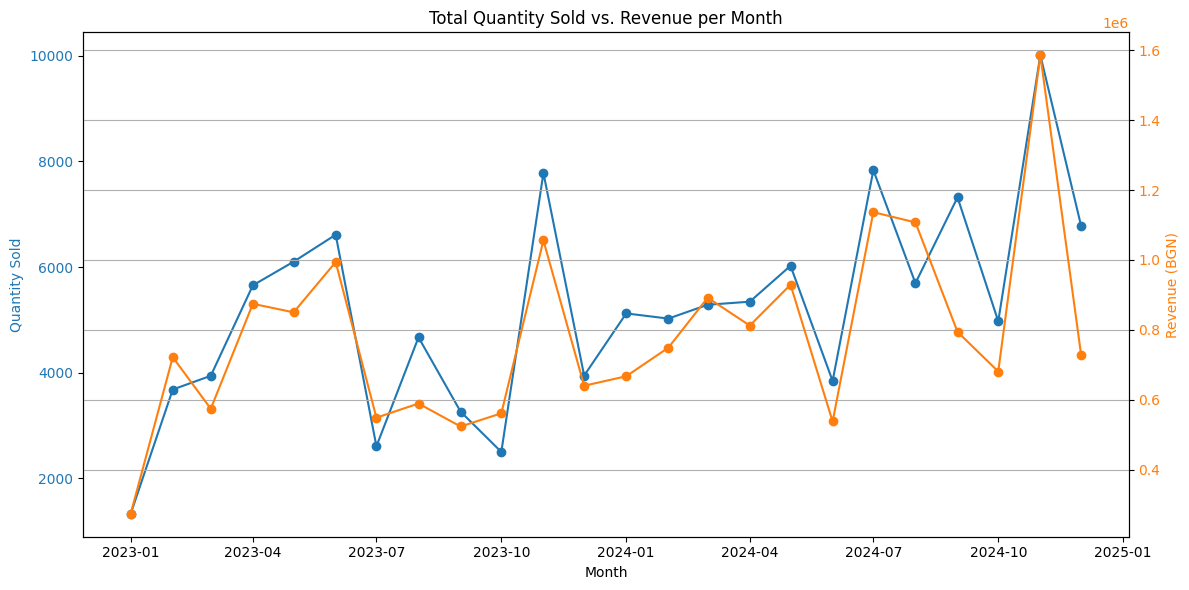

In [43]:
monthly_summary = (
    merged_df
    .groupby('Month')
    .agg({
        'Quantity': 'sum',
        'Revenue': 'sum' 
    })
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Quantity Sold', color=color)
ax1.plot(monthly_summary['Month'], monthly_summary['Quantity'], marker='o', color=color, label='Total Quantity Sold')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Revenue (BGN)', color=color)
ax2.plot(monthly_summary['Month'], monthly_summary['Revenue'], marker='o', color=color, label='Total Revenue')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Total Quantity Sold vs. Revenue per Month')
fig.tight_layout()
plt.grid(True)
plt.show()


### Total Quantity Sold vs. Revenue per Month:
It is immediate that most months show a positive correlation between units sold and revenue, which in other words means that when quantity goes up, revenue also goes up. Another thing we clearly see is that every November there is a huge spike in total quantities sold and revenue. According to our stakeholder from the interview when asked about this he commented that, because it due to the wolrd wide known promotion "Black Friday" and also because of December holidays and presents, which babies also receive.

Of course there are some months, which underperform others like September and January. And again according to our stakeholder he said that these are their lowest demand months and out of all months these particilarly two always underperform. "That is why they set our goals for those months lower"- stakeholder added.

As I said we can dive deeper to analyze certain patterns we see and to do that we should see acutlaly what products/categories drive success and also products which struggle during key periods.

Let's now get to know our products even more and see which are the best-sellers during November.

November is one of the strongest months in terms of both units sold and total revenue. According to stakeholder input, this is largely driven by Black Friday promotions and holiday-related purchases. The goal here is to identify the top-performing products during this period.

C:\Users\User\AppData\Local\Temp\ipykernel_39280\208041095.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


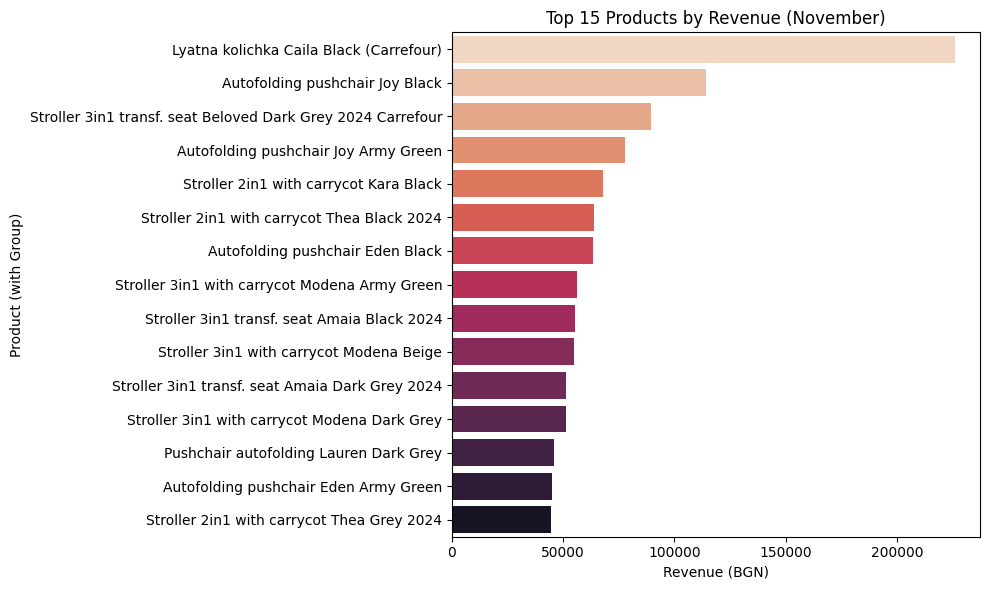

In [44]:
november_sales = merged_df[merged_df['Month'].dt.month == 11]

top_november_products = (
    november_sales
    .groupby(['SKU', 'Product Description', 'Product Group Label'])[['Quantity', 'Revenue']]
    .sum()
    .sort_values(by='Revenue', ascending=False)
    .head(15)
    .reset_index()
)

top_november_products['Label'] = top_november_products['Product Description']


plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_november_products.sort_values(by='Revenue'),
    y='Label',
    x='Revenue',
    palette='rocket'
)
plt.title('Top 15 Products by Revenue (November)')
plt.xlabel('Revenue (BGN)')
plt.ylabel('Product (with Group)')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


- The top-selling product in November is _"Lyatna kolichka Caila Black (Carrefour)"_, selling over 2,000 units with revenue exceeding 220,000 BGN.  
- According to the stakeholder, this product is exclusive to **Carrefour Spain**, a major client, and is **heavily stocked ahead of Black Friday**.  
- Other top performers include **autofolding pushchairs** and **3in1 strollers**, which are perceived as premium gifts for babies.

Let’s evaluate how different November really is. Because the way it was looking from the first graph it could be a potential outlier month. 

To do that let's add a new column `Is_November`, which we will also use for the model and see what percentage of total sales (across the whole dataset) happened in November and later on we are going to compare average quantity and revenue per product in November vs. other months.

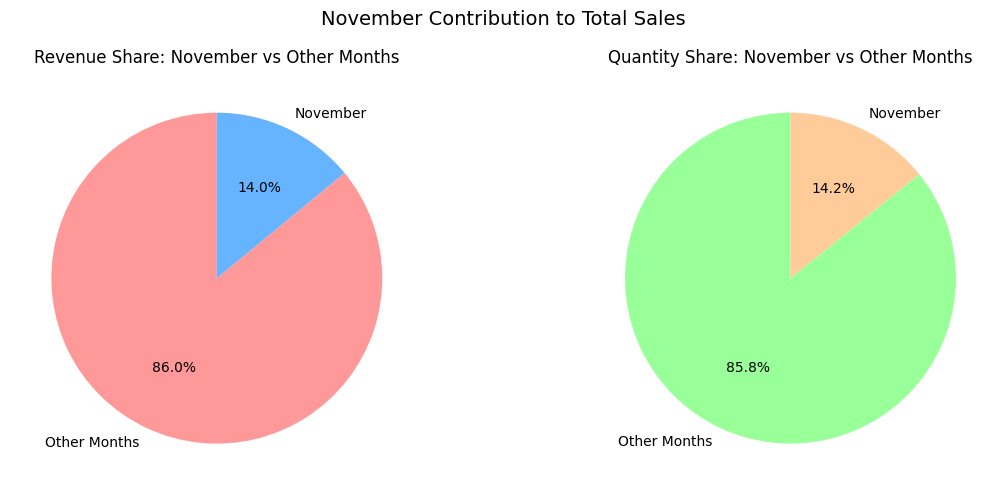

In [45]:
merged_df['Is_November'] = merged_df['Month'].dt.month == 11

total_summary = (
    merged_df
    .groupby('Is_November')[['Quantity', 'Revenue']]
    .sum()
    .rename(index={True: 'November', False: 'Other Months'})
    .reset_index()
    .rename(columns={'Is_November': 'Period'})
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].pie(
    total_summary['Revenue'], 
    labels=total_summary['Period'], 
    autopct='%1.1f%%', startangle=90,
    colors=['#ff9999', '#66b3ff']
)
axes[0].set_title('Revenue Share: November vs Other Months')

axes[1].pie(
    total_summary['Quantity'], 
    labels=total_summary['Period'], 
    autopct='%1.1f%%', startangle=90,
    colors=['#99ff99', '#ffcc99']
)
axes[1].set_title('Quantity Share: November vs Other Months')

plt.suptitle('November Contribution to Total Sales', fontsize=14)
plt.tight_layout()
plt.show()


To further investigate if the above pie chart is true let's see the revenue of other months as well.

In [46]:
monthly_totals = merged_df.groupby(merged_df['Month'].dt.month)[['Quantity', 'Revenue']].sum()
monthly_totals['Revenue Share (%)'] = (monthly_totals['Revenue'] / monthly_totals['Revenue'].sum()) * 100
monthly_totals['Quantity Share (%)'] = (monthly_totals['Quantity'] / monthly_totals['Quantity'].sum()) * 100
display(monthly_totals)

,Quantity,Revenue,Revenue Share (%),Quantity Share (%)
Month,,,,
1,6452,940358.46,4.994767,5.146777
2,8707,1470581.78,7.811077,6.945597
3,9229,1466004.57,7.786765,7.361997
4,11000,1686847.87,8.959787,8.774729
5,12127,1779306.51,9.450886,9.673740
6,10457,1531652.74,8.135459,8.341576
7,10442,1685375.47,8.951966,8.329611
8,10366,1696564.05,9.011395,8.268985
9,10584,1317384.53,6.997362,8.442884


From the above pie chart and comparison table we can only conclude that while November represents only one month out of twelve, it brings in a significantly larger share compared to any other individual month, nearly doubling the contribution of months like January or October.

This trend reinforces the need for stockpiling in advance and marketing prioritization during Q4.
Going forward, this knowledge can be baked into demand forecasting models, adjusting procurement decisions and promotional timing accordingly.

C:\Users\User\AppData\Local\Temp\ipykernel_39280\3660409964.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\User\AppData\Local\Temp\ipykernel_39280\3660409964.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


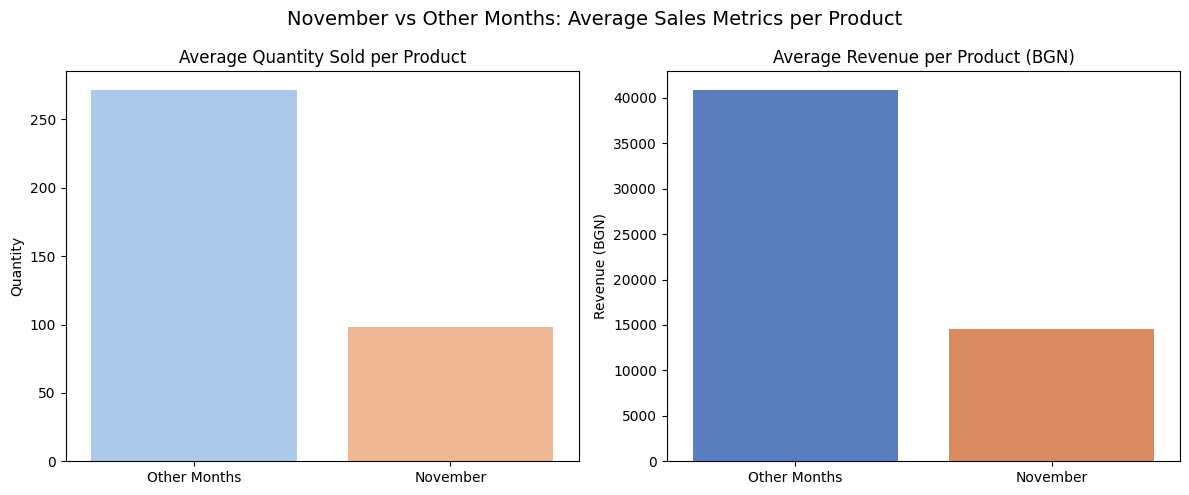

In [47]:
nov_vs_other = (
    merged_df
    .groupby(['SKU', 'Is_November'])[['Quantity', 'Revenue']]
    .sum()
    .reset_index()
)

summary = (
    nov_vs_other
    .groupby('Is_November')[['Quantity', 'Revenue']]
    .mean()
    .rename(index={True: 'November', False: 'Other Months'})
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

sns.barplot(
    data=summary.reset_index(),
    x='Is_November',
    y='Quantity',
    ax=axes[0],
    palette='pastel'
)
axes[0].set_title('Average Quantity Sold per Product')
axes[0].set_ylabel('Quantity')
axes[0].set_xlabel('')

sns.barplot(
    data=summary.reset_index(),
    x='Is_November',
    y='Revenue',
    ax=axes[1],
    palette='muted'
)
axes[1].set_title('Average Revenue per Product (BGN)')
axes[1].set_ylabel('Revenue (BGN)')
axes[1].set_xlabel('')

plt.suptitle('November vs Other Months: Average Sales Metrics per Product', fontsize=14)
plt.tight_layout()
plt.show()


Now we caught something interesting here. Contrary to our expectations, November has lower average sales per product in both quantity and revenue. The average quantity per product is nearly 3x higher during other months. Same for revenue — significantly higher for other months compared to November. Earlier, we saw total revenue and quantity spike in November — yet here the per-product average is lower. 

This can only imply **ONE** thing: More products are sold overall in November, but across more SKUs, meaning there’s broader interest across the catalog.

Each individual product sells slightly less on average, but the total rises due to increased variety of products sold.

✅ Out of this graphs we can conclude that **Black Friday** and **holiday periods** increase catalog-wide engagement and stock planning in November needs to ensure wide availability, not just of top products.

Now that we know our best-sellers in the best selling month. How about the worse selling products during January and September(the months with lowest turnover)

C:\Users\User\AppData\Local\Temp\ipykernel_39280\3691641405.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


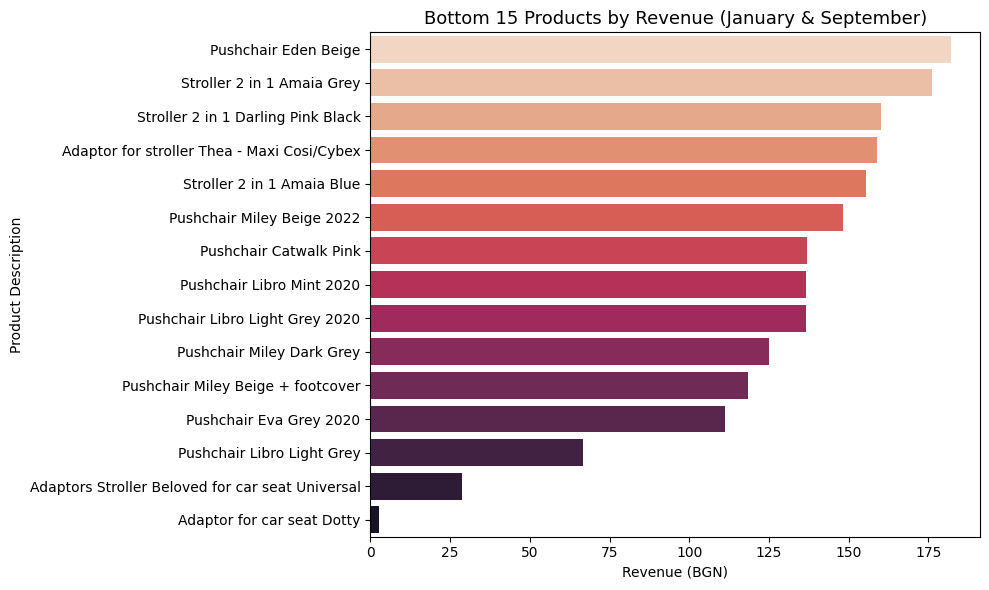

In [48]:
low_months = merged_df[merged_df['Month'].dt.month.isin([1, 9])]

low_month_products = (
    low_months
    .groupby(['SKU', 'Product Description'])[['Quantity', 'Revenue']]
    .sum()
    .sort_values(by='Revenue', ascending=True)
    .head(15)
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=low_month_products.sort_values(by='Revenue'),
    y='Product Description',
    x='Revenue',
    palette='rocket'
)
plt.title('Bottom 15 Products by Revenue (January & September)', fontsize=13)
plt.xlabel('Revenue (BGN)')
plt.ylabel('Product Description')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

We can see that products like adaptors and older strollers don't sell at all in slow months, because these are low priority in stocking or forecasting for Jan/Sep
Older models like "Libro Light Grey 2020" or "Catwalk Pink" barely register and Low-selling products have similar names to bestsellers. 

Maybe before we analyzed the products themselves it could've been better analyze their own representative categories.

,Quantity,Revenue
Product Group Label,,
Bebeshki letni kolichki,83379,8994130.80
Kombinirani bebeshki kolichki 3 v 1,23612,6474353.12
Kombinirani bebeshki kolichki 2 v 1,9123,2906081.93
Bebeshki kolichki za bliznatsi,1119,291777.11
Aksesoari za kolichki,6911,146905.55
Adaptori za bebeshka kolichka,1196,8952.61
Obiknoveni bebeshki kolichki,18,2689.73
Cybex,2,1984.33


C:\Users\User\AppData\Local\Temp\ipykernel_39280\3380830028.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


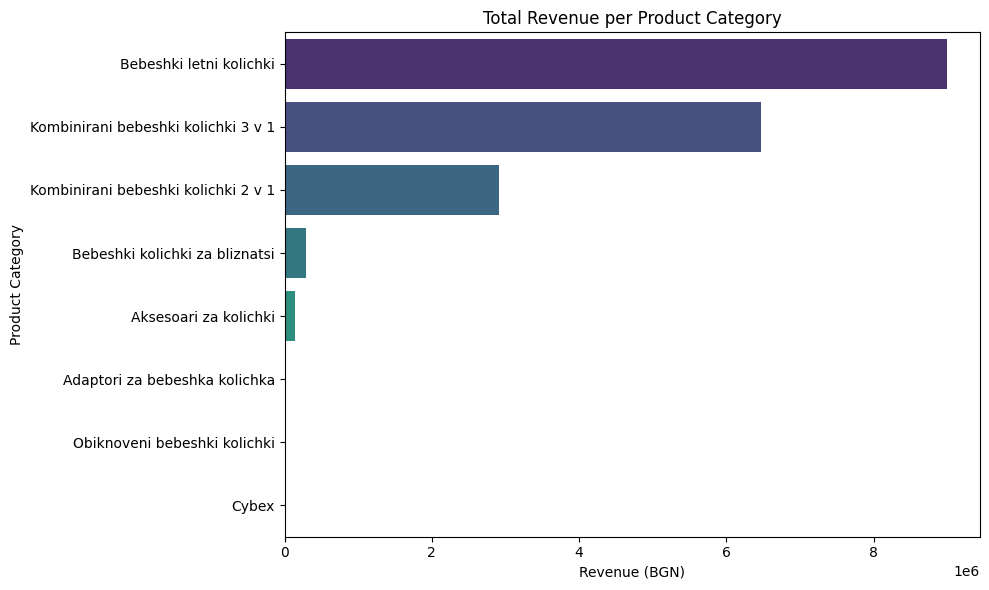

In [49]:
category_summary = (
    merged_df
    .groupby('Product Group Label')[['Quantity', 'Revenue']]
    .sum()
    .sort_values(by='Revenue', ascending=False)
)

display(category_summary)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=category_summary.reset_index(),
    y='Product Group Label',
    x='Revenue',
    palette='viridis'
)
plt.title('Total Revenue per Product Category')
plt.xlabel('Revenue (BGN)')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()


We should immedietely get the clear things out of the way and that is indeed the three main category leaders - ``Bebeshki letni kolichki`` (Summer baby strollers), Followed by ``(3-in-1 strollers)`` and ``(2-in-1 strollers)`` - they all dominate both quantity sold and revenue.

`Adaptori za bebeshka kolichka` or Adapters for baby strollers, `Obiknoveni bebeshki kolichki` or Normal baby strollers, `Cybex` contribute negligible revenue.

Some of these might be discontinued products or simply have low demand.

Now that we know our best categories we can further analyze them by plotting their montly revenue trends and see if certain categories sell better in different time periods.

C:\Users\User\AppData\Local\Temp\ipykernel_39280\79293263.py:27: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


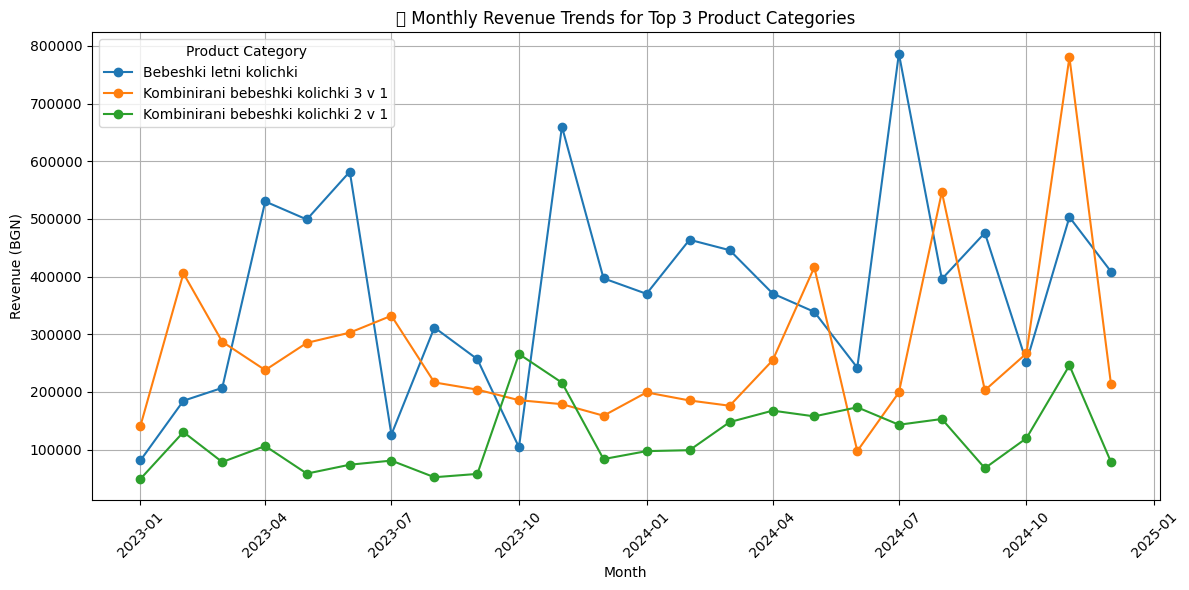

In [50]:
top_3_categories = [
    'Bebeshki letni kolichki',
    'Kombinirani bebeshki kolichki 3 v 1',
    'Kombinirani bebeshki kolichki 2 v 1'
]

filtered_data = merged_df[merged_df['Product Group Label'].isin(top_3_categories)]

monthly_category_revenue = (
    filtered_data
    .groupby(['Month', 'Product Group Label'])['Revenue']
    .sum()
    .reset_index()
)

plt.figure(figsize=(12, 6))
for group in top_3_categories:
    subset = monthly_category_revenue[monthly_category_revenue['Product Group Label'] == group]
    plt.plot(subset['Month'], subset['Revenue'], marker='o', label=group)

plt.title('📈 Monthly Revenue Trends for Top 3 Product Categories')
plt.xlabel('Month')
plt.ylabel('Revenue (BGN)')
plt.xticks(rotation=45)
plt.legend(title='Product Category')
plt.grid(True)
plt.tight_layout()
plt.show()


1. Summer strollers / Bebeshki letni kolichki

Clear seasonal peaks are May–July and November. These strollers are strongly season-dependent, peaking during late spring and summer (likely for vacations, outdoor use). Notable secondary spike in November, possibly driven by Black Friday + gift season. All of this means stock levels should be increased startin in April.

2. 3-in-1 Strollers / Kombinirani bebeski kolichki 3 v 1 

More balanced demand with bumps in March–May, September–November.
These are all-season functional items (usually purchased by new parents regardless of season). Sales climb in early spring and again in fall, possibly tied to family planning trends or retailer promotions.

3. 2-in-1 Strollers / Kombinirani bebeski kolichki 2 v 1

Lowest sales and also they showcase a relatively flat trend
Possibly less preferred due to fewer features compared to 3-in-1 strollers. Likely to be price-driven or niche.

Now another valuable insight that we missed and our consultant pointed out is whether if the company had any 'stopped' or discontinued products in their catalog.

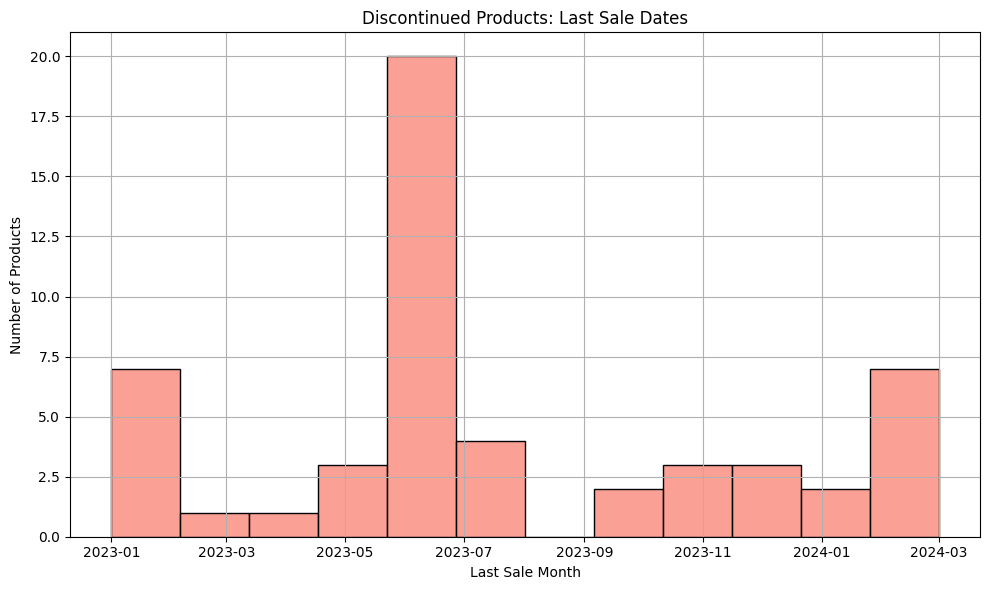

In [51]:
cutoff_month = merged_df['Month'].max() - pd.DateOffset(months=6)

discontinued = (
    merged_df[(merged_df['Current_Stock'] == 0)]
    .groupby('SKU')
    .agg(
        Last_Sale=('Month', 'max'),
        Total_Sales=('Quantity', 'sum'),
        Product_Name=('Product Description', 'first')
    )
    .query('Last_Sale < @cutoff_month')
    .sort_values(by='Last_Sale')
)

plt.figure(figsize=(10, 6))
sns.histplot(discontinued['Last_Sale'], bins=12, color='salmon')
plt.title('Discontinued Products: Last Sale Dates')
plt.xlabel('Last Sale Month')
plt.ylabel('Number of Products')
plt.grid(True)
plt.tight_layout()
plt.show()


There is a noticeable spike around May–June 2023, suggesting a large number of products (around 20) made their last appearance in that time window. When asked, the stakeholder said that during this period the company made a decision to cut out a huge part of their products, due to the limited product management and problems that they were facing, when handling a lot of strollers. 

Also a few products have their last sale in late 2023 or early 2024, which may imply that discountinuation slowed and fewer products are reaching their EOL (end of life) recently after the huge cut in the summer of 2023.

Now to actually what percentage of all products are discontinued let's see how many SKUs are stopped vs. active.

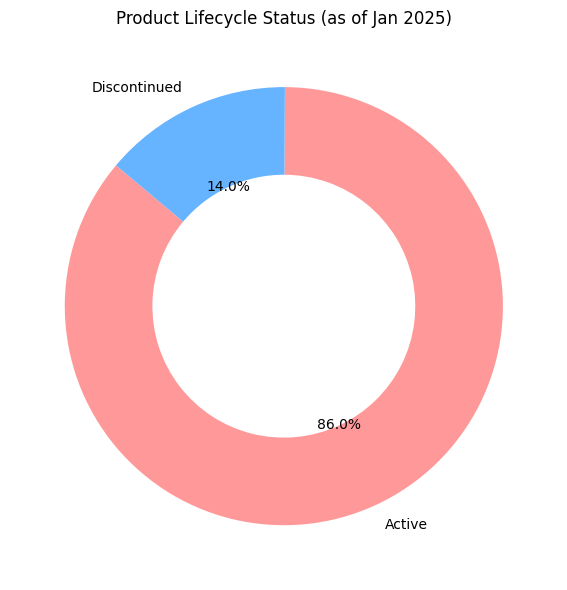

In [52]:
last_sale = (
    merged_df.groupby('SKU')['Month']
    .max()
    .reset_index()
    .rename(columns={'Month': 'Last_Sale_Date'})
)

stock_status = merged_df[['SKU', 'Current_Stock']].drop_duplicates()
status_df = pd.merge(last_sale, stock_status, on='SKU', how='left')

today = pd.to_datetime('2025-01-01')  
cutoff_date = today - pd.DateOffset(months=6)

status_df['Status'] = 'Active'
status_df.loc[
    (status_df['Current_Stock'] == 0) & (status_df['Last_Sale_Date'] < cutoff_date),
    'Status'
] = 'Discontinued'

status_counts = status_df['Status'].value_counts()

plt.figure(figsize=(6, 6))
colors = ['#ff9999', '#66b3ff']
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops=dict(width=0.4))
plt.title("Product Lifecycle Status (as of Jan 2025)")
plt.tight_layout()
plt.show()

So from the Product Lifecycle donut chart we can clearly see that only 14% of Products are likely discontinued. These are products with:
- Zero current stock
- And no sales in the past 6+ months (as of Jan 2025)

This suggests they are either:
- Fully phased out,
- Not in production anymore,
- Or not being restocked by the business.

Having ~1 in 7 SKUs discontinued might be a healthy product turnover rate, depending on:

- Whether those discontinued items were poor performers,
- And if they're being replaced by new or improved versions.

Let's check and see.

C:\Users\User\AppData\Local\Temp\ipykernel_39280\3214494943.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


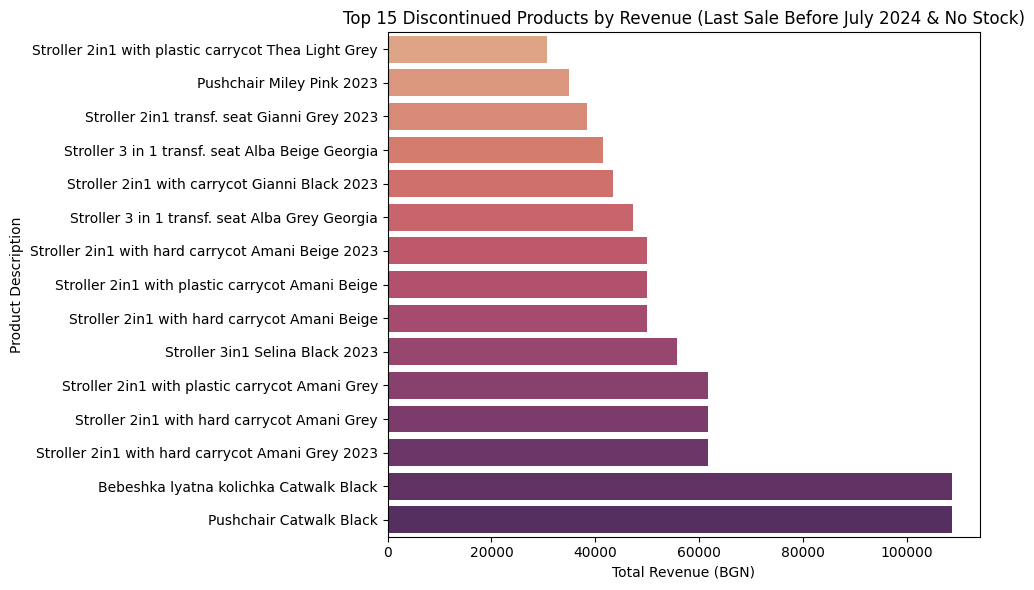

In [53]:
cutoff_date = pd.to_datetime("2025-01-01")
six_months_ago = cutoff_date - pd.DateOffset(months=6)

last_sale = merged_df.groupby('SKU')['Month'].max().reset_index()
last_sale['Status'] = last_sale['Month'] < six_months_ago  # Discontinued if no sale in last 6 months

stock = merged_df.groupby('SKU')['Current_Stock'].max().reset_index()

status_df = pd.merge(last_sale, stock, on='SKU')
status_df['Status'] = (status_df['Current_Stock'] == 0) & (status_df['Month'] < six_months_ago)

# Step 4: Calculate total performance per SKU
performance = (
    merged_df
    .groupby('SKU')[['Quantity', 'Revenue']]
    .sum()
    .reset_index()
)

product_names = merged_df[['SKU', 'Product Description']].drop_duplicates()
performance = performance.merge(product_names, on='SKU', how='left')

performance_summary = pd.merge(performance, status_df[['SKU', 'Status']], on='SKU', how='left')

top_discontinued = (
    performance_summary[performance_summary['Status'] == True]
    .sort_values(by='Revenue', ascending=False)
    .head(15)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_discontinued.sort_values(by='Revenue'),
    x='Revenue',
    y='Product Description',
    palette='flare'
)
plt.title('Top 15 Discontinued Products by Revenue (Last Sale Before July 2024 & No Stock)')
plt.xlabel('Total Revenue (BGN)')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()

Now from the graph, we can clearly conclude that some discontinued products had strong sales performance, both in quantity and revenue. This can only imply that several SKUs with 50,000+ BGN revenue were discontinued and that maybe they were not phased out due to poor performance, but likely for:
- Supply chain issues
- Model replacements
- Seasonal or campaign-based discontinuation
- Strategic decisions (e.g. market repositioning) 

So what we can do with this information is maybe either to flag high-performing discontinued products to product managers so they can consider bringing them back and include this in forecasting and see the demand for similar models may still exist → incorporate this insight in new launches.

## 📃 Preprocessing 

To prepare our data for predictive modeling, we should generate features that provide temporal context and help the model learn SKU-specific sales patterns over time. Let's add them and after I am going to explain what each of those does.


In [54]:
merged_df.head(5)

,SKU,Product Description,Month,Quantity,Revenue,Current_Stock,Extracted_Group_Code,Product Group Label,Is_November
0,31001010007,Stroller 3 in 1 Allure Lilac,2024-12-01,2,623.88,0,100101,Kombinirani bebeshki kolichki 3 v 1,False
1,31001010045,Stroller 3 in 1 Madrid Green Melange,2024-12-01,1,250.00,5,100101,Kombinirani bebeshki kolichki 3 v 1,False
2,31001010055,Stroller 3in1 transf. seat Darling Beige,2023-01-01,3,683.96,9,100101,Kombinirani bebeshki kolichki 3 v 1,False
3,31001010055,Stroller 3in1 transf. seat Darling Beige,2023-02-01,2,435.88,9,100101,Kombinirani bebeshki kolichki 3 v 1,False
4,31001010055,Stroller 3in1 transf. seat Darling Beige,2024-12-01,1,201.36,9,100101,Kombinirani bebeshki kolichki 3 v 1,False


In [55]:
merged_df = merged_df.sort_values(by=['SKU', 'Month'])

for lag in [1, 2, 3]:
    merged_df[f'Lag_{lag}'] = (
        merged_df
        .groupby('SKU')['Quantity']
        .shift(lag)
    )

merged_df['Rolling_Mean_3'] = (
    merged_df
    .groupby('SKU')['Quantity']
    .shift(1)
    .rolling(window=3)
    .mean()
    .reset_index(level=0, drop=True)
)

merged_df['Rolling_Mean_6'] = (
    merged_df
    .groupby('SKU')['Quantity']
    .shift(1)
    .rolling(window=6)
    .mean()
    .reset_index(level=0, drop=True)
)

merged_df['Month_Num'] = merged_df['Month'].dt.month
merged_df['Year'] = merged_df['Month'].dt.year

first_month = (
    merged_df
    .groupby('SKU')['Month']
    .transform('min')
)
merged_df['Is_New'] = merged_df['Month'] == first_month

merged_df.head(5)


,SKU,Product Description,Month,Quantity,Revenue,Current_Stock,Extracted_Group_Code,Product Group Label,Is_November,Lag_1,Lag_2,Lag_3,Rolling_Mean_3,Rolling_Mean_6,Month_Num,Year,Is_New
0,31001010007,Stroller 3 in 1 Allure Lilac,2024-12-01,2,623.88,0,100101,Kombinirani bebeshki kolichki 3 v 1,False,NaN,NaN,NaN,NaN,NaN,12,2024,True
1,31001010045,Stroller 3 in 1 Madrid Green Melange,2024-12-01,1,250.00,5,100101,Kombinirani bebeshki kolichki 3 v 1,False,NaN,NaN,NaN,NaN,NaN,12,2024,True
2,31001010055,Stroller 3in1 transf. seat Darling Beige,2023-01-01,3,683.96,9,100101,Kombinirani bebeshki kolichki 3 v 1,False,NaN,NaN,NaN,NaN,NaN,1,2023,True
5,31001010055,Stroller 3in1 transf. seat Darling Beige 2020,2023-01-01,2,441.08,9,100101,Kombinirani bebeshki kolichki 3 v 1,False,3.0,NaN,NaN,2.333333,NaN,1,2023,True
3,31001010055,Stroller 3in1 transf. seat Darling Beige,2023-02-01,2,435.88,9,100101,Kombinirani bebeshki kolichki 3 v 1,False,2.0,3.0,NaN,NaN,NaN,2,2023,False


Lag Features (`Lag_1`, `Lag_2`, `Lag_3`)
These columns represent the **quantity sold in previous months** (1 to 3 months ago). They help the model understand short-term trends like:

- Recent dips or spikes in demand
- How recent months affect the current month

Rolling Averages (`Rolling_Mean_3`, `Rolling_Mean_6`)
These features capture the **average quantity sold over the past 3 or 6 months**, excluding the current month. They help the model detect:

- Seasonality or gradual demand changes
- Smoothed out versions of volatility

Temporal Features (`Month_Num`, `Year`)
These help the model detect **seasonal patterns** across months and years. For example:

- Summer strollers may peak in warm months
- 3-in-1 strollers may sell more in colder seasons

Is_New
A boolean column that is `True` if this is the **first month the SKU appears** in the dataset. This is important because:

- New products often behave differently from mature ones
- It may help the model apply more conservative predictions for new SKUs

*Note*: Each SKU appears once **per month**, so the dataset is organized in a `SKU x Month` grid. This is intentional and correct, as our goal is to predict demand for each SKU each month.

Now before we make a correlation heatmap we should consider adding new features not only from previous iterations, but also features that based on the visualizations can potentially boost our model.

1. Label Encoding `Extracted_Group_Code`
We should start off with encoding the product group into integers for use in models.

In [56]:
from sklearn.preprocessing import LabelEncoder

group_encoder = LabelEncoder()
merged_df['Group_Code_Encoded'] = group_encoder.fit_transform(merged_df['Extracted_Group_Code'])


2. `Months_Since_Last_Sale`
This captures recent inactivity — how long ago the product was last sold.
Helps the model know if a product has become obsolete or unpopular.

In [57]:
from dateutil.relativedelta import relativedelta

last_sale_month = merged_df.groupby('SKU')['Month'].transform('max')

reference_date = pd.to_datetime('2025-01-01')

def diff_months(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

merged_df['Months_Since_Last_Sale'] = last_sale_month.apply(lambda x: diff_months(reference_date, x))


3. `Is_Discontinued`

Based on our donut chart on discontinued products (no stock + no sales after July 2024) we saw that they are in fact discontinued productsand maybe they should be tracked. That way the model will learn which products are no longer relevant for forecasting future sales and prevents over-forecasting for SKUs that are phasing out.


In [58]:
last_sale_per_sku = merged_df.groupby('SKU')['Month'].transform('max')
merged_df['Is_Discontinued'] = (last_sale_per_sku < '2024-07-01') & (merged_df['Current_Stock'] == 0)

4. `Belongs_to_Top_3_Groups`

Based on our line chart of top 3 product categories by revenue trend the model can learn that products in leading groups often have more stable and higher demand. This feature will act as a proxy for product popularity or strategic focus.


In [59]:
top_3_groups = ['100101', '100102', '100103']
merged_df['Belongs_to_Top_3_Groups'] = merged_df['Extracted_Group_Code'].isin(top_3_groups)

5. `Stockout_Risk`

We add this, because not only is it useful for very useful in predictive inventory management, but also that way we flag products that are selling fast but might run out of stock.

In [60]:
merged_df['Stockout_Risk'] = (merged_df['Current_Stock'] <= 5) & (merged_df['Quantity'] >= merged_df['Quantity'].quantile(0.75))

In [61]:
merged_df.head(5)

,SKU,Product Description,Month,Quantity,Revenue,Current_Stock,Extracted_Group_Code,Product Group Label,Is_November,Lag_1,...,Rolling_Mean_3,Rolling_Mean_6,Month_Num,Year,Is_New,Group_Code_Encoded,Months_Since_Last_Sale,Is_Discontinued,Belongs_to_Top_3_Groups,Stockout_Risk
0,31001010007,Stroller 3 in 1 Allure Lilac,2024-12-01,2,623.88,0,100101,Kombinirani bebeshki kolichki 3 v 1,False,NaN,...,NaN,NaN,12,2024,True,0,1,False,True,False
1,31001010045,Stroller 3 in 1 Madrid Green Melange,2024-12-01,1,250.00,5,100101,Kombinirani bebeshki kolichki 3 v 1,False,NaN,...,NaN,NaN,12,2024,True,0,1,False,True,False
2,31001010055,Stroller 3in1 transf. seat Darling Beige,2023-01-01,3,683.96,9,100101,Kombinirani bebeshki kolichki 3 v 1,False,NaN,...,NaN,NaN,1,2023,True,0,1,False,True,False
5,31001010055,Stroller 3in1 transf. seat Darling Beige 2020,2023-01-01,2,441.08,9,100101,Kombinirani bebeshki kolichki 3 v 1,False,3.0,...,2.333333,NaN,1,2023,True,0,1,False,True,False
3,31001010055,Stroller 3in1 transf. seat Darling Beige,2023-02-01,2,435.88,9,100101,Kombinirani bebeshki kolichki 3 v 1,False,2.0,...,NaN,NaN,2,2023,False,0,1,False,True,False


Now with a heatmap let's see the correlation between those new features we added and also old ones from previous iterationss and whether we should drop some.

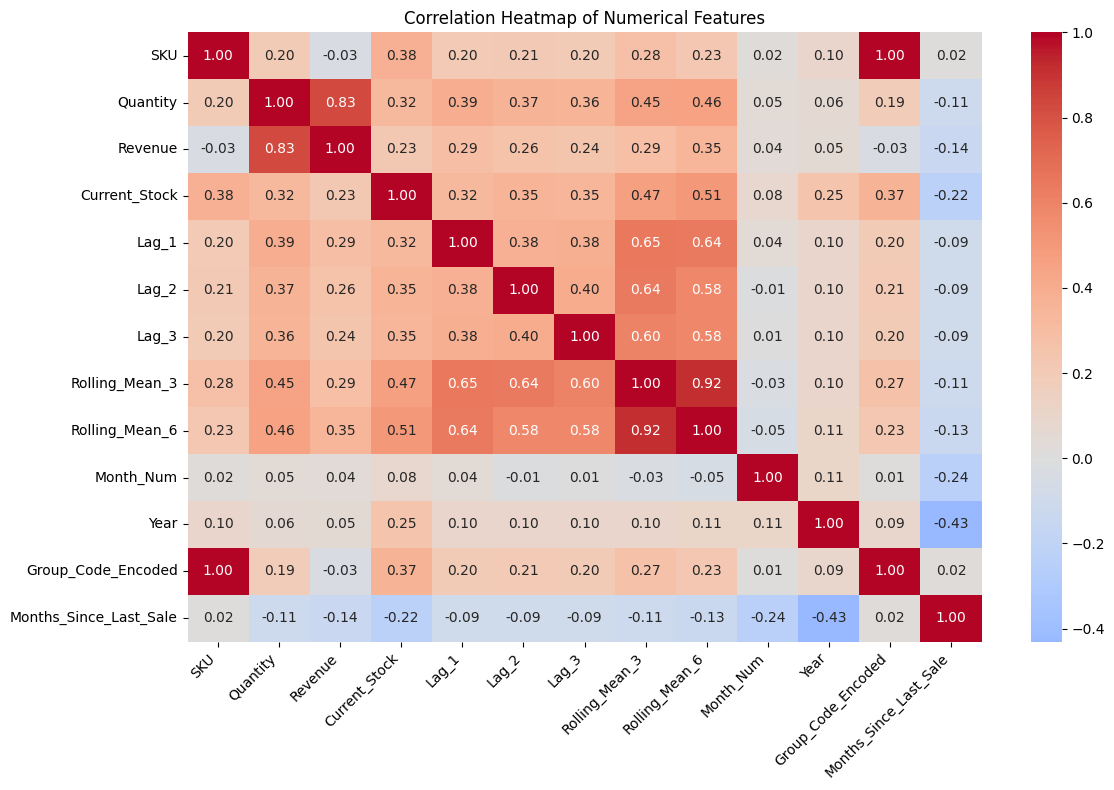

In [62]:
numeric_features = merged_df.select_dtypes(include=['number'])

corr_matrix = numeric_features.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Based on the correlation heatmap we can immediatelly evaluate that the strong correlations with `Quantity` are:

1. `Revenue` (0.83):
As expected, the number of units sold is highly correlated with revenue — more units sold equals more revenue.
2. `Rolling_Mean_6` (0.46) and `Rolling_Mean_3` (0.45):
Strong indicators of recent demand. These rolling means smooth out short-term fluctuations, helping capture trends.
3. `Lag_1`, `Lag_2`, `Lag_3` (0.36–0.39):
Previous months’ sales are moderately predictive — as expected in time series. The effect slightly weakens as the lag increases.

Of course there are some negative correlations with `Quantity` like `Months_Since_Last_Sale` (-0.14), which is a small but meaningful inverse correlation. Products that haven't sold recently tend to have lower current sales. Also `Year` with -0.06, which is weakly negative. Possibly because earlier products (from 2023) are no longer selling — could hint at obsolescence. 

So after we saw the heatmap we can immediatelly say that `Revenue` should be dropped due to its high correlation, but since we’re predicting Quantity (not revenue), we exclude Revenue from modeling to avoid potential data leakage (i.e., using post-sale information to predict the sale itself). The others we are going to leave, because our planned **XGBoost** model can detect non-linear interaction effects even wehn individual correlations are low. Also weak correlation does not imply no predictive value — especially in complex demand behavior involving seasonality, product lifecycle, and stock dynamics.


## 🪓 Splitting into train/test

Now that we have identified the features for this iteration we are going to split our dataset into train/test sets. Additionally it is most important to mention our target variable, which is `Quantity`.

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

model_df = merged_df.copy()

label_encoders = {}
categorical_features = ['Product Group Label', 'Is_November', 'Is_New', 'Is_Discontinued', 'Belongs_to_Top_3_Groups', 'Stockout_Risk']

for col in categorical_features:
    le = LabelEncoder()
    model_df[col] = le.fit_transform(model_df[col])
    label_encoders[col] = le

features = [
    'Current_Stock',
    'Lag_1', 'Lag_2', 'Lag_3',
    'Rolling_Mean_3', 'Rolling_Mean_6',
    'Month_Num', 'Year',
    'Group_Code_Encoded',
    'Months_Since_Last_Sale',
    # Categorical
    'Product Group Label',
    'Is_November',
    'Is_New',
    'Is_Discontinued',
    'Belongs_to_Top_3_Groups',
    'Stockout_Risk'
]

model_df = model_df.dropna(subset=features + ['Quantity'])

X = model_df[features]
y = model_df['Quantity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 🧠 Explainable AI (XAI) Considerations

Before we go to modelling, to gain trust from supply chain managers and decision-makers, model predictions must be interpretable. We use interpretable models like Logistic Regression in early stages, and analyze feature importance to explain why certain products are recommended for restocking.

This ensures decisions are not made blindly based on "black-box" outputs.

## 🧪 Modelling

Once the features were engineered and cleaned (including handling NaNs due to lag and rolling operations), we can now proceed with the model training phase. The goal is to predict the monthly quantity sold of a product using its historical data (lags, rolling means, date features, etc.).

We started with a Linear Regression model as a baseline due to its simplicity and interpretability. It basically helps us understand if there's a linear relationship between features like past sales, rolling averages, and the current month's sales.

In [64]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
result = lr_model.fit(X_train, y_train)
score = lr_model.score(X_test, y_test)
print("R²:", score)

R²: 0.2477952896522989


If we compare this result to previous Iterations , where our results were:

1. Iteration 0 R² ≈ 0.01
&
2. Iteration 1 R² ≈ 0.24

The jump from 0.01 to 0.24 that happened in Iteration 1 cannot be beaten in this one, even after adding more features and also more in-depth dataset cleaning. But an R² of 0.247 for a **basic model** like this is decent. It suggests that some relationships in our data are still linear in nature, but it's not enough to capture all complexities (like seasonality, interactions, etc.).


In [65]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = lr_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Max Error: {mae:.2f}, Mean squared error: {mse:.2f}, Root mean squared error: {rmse:.2f}")

Max Error: 47.94, Mean squared error: 13521.84, Root mean squared error: 116.28


Right off the bat we can say that:

**Max Error** - 49.95 indicates that the worst-case prediction was off by almost 50 units. While it’s not catastrophic in isolation, it suggests that for certain products or months, the model significantly under- or overestimated demand. These outliers could be due to:
- Sudden sales spikes (November)
- New products with no historical patterns
- Products with low or inconsistent sales history


**Mean Squared Error** - 14110.58 meaning the model is sensitive to large errors, and this relatively high value confirms that a few large mispredictions are heavily impacting the average. It suggests our model performs well on average, but struggles with a few unpredictable cases.

**Root Mean Squared Error** - 118.79 - gives us the typical magnitude of error in the same units as our prediction target (quantity sold). An RMSE of ~117 means that, on average, the model is off by around 117 units per product-month. For products with large volume sales, this could be acceptable; however, for low-volume items, it could be a significant percentage error.

Also as we mentioned, because we did **RandomForestRegressor** in Iteration 0 let's also do it in this one.

In [66]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
print("R²:", rf_score)

R²: 0.2778435440655157


And now we have finally passed the mark of 0.25 and reached almost 0.28 with our RandomForestRegressor. We can say that this is the first time out of all Iterations that **RandomForestRegressor** is performing better than other models. With an R² of 0.277, it currently explains the most variance in our demand (quantity sold). This makes sense, because it not only captures non-linear relationships, but also it's robust to outliers and requires less feature scaling. We can also mention that it handles mixed types of features well, which is useful since your dataset contains both *numerical* and *categorical* features.

As it shows potential let's see if we reduce noise by feature selection more properly for this model alone.

C:\Users\User\AppData\Local\Temp\ipykernel_39280\1510659521.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_39280\1510659521.py:12: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


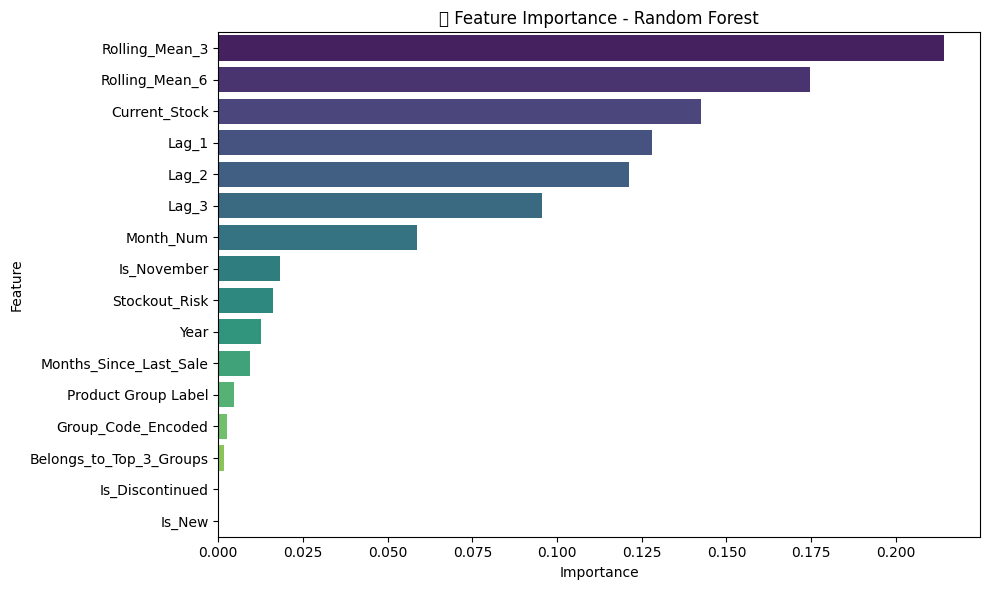

In [67]:
importances = rf.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('🔍 Feature Importance - Random Forest')
plt.tight_layout()
plt.show()


As we can see from the graph `Is_New`, `Is_Discontinued`, `Belongs_to_Top_3_Groups`, etc., offer limited predicitve value, but removing them won't drastically affect performance (also why we did not drop them initially, when analyzing the heatmap), they may help generalization.

Let's try another approach and that is to fine tune the best *Hyperparameters* for the `RandomForest` using **RandomizedSearchCV**, which in contrast to **GridSearchCV**, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

In [68]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_
print("Best R² Score:", random_search.best_score_)
print("Best Parameters:", random_search.best_params_)


Best R² Score: 0.3011315560592736
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10}


For first we get a score above *0.30*, which in our books is a win. R² = 0.30 means the model now explains 30% of the variance in monthly sales (Quantity). While this isn’t extremely high, it’s a strong baseline given the real-world complexity of demand prediction and the noisy nature of sales data. The improvement suggests that hyperparameter tuning made the model better at generalizing.

- `n_estimators=100`: A reasonable number of trees. More might improve performance slightly but with diminishing returns.

- `max_depth=10`: Limits tree depth to avoid overfitting. Suggests that sales patterns are not too deeply nested.

- `min_samples_split=10`, min_samples_leaf=4: These add regularization by requiring nodes to have a minimum number of samples. This reduces variance.

- `max_features='log2'`: Encourages each tree to use fewer features — reducing overfitting and promoting model diversity.

Now to further better it we can include this model in an ensemble model, but before we get to it, let's see another model that we researched and which a lot of similar algorithms already use and that is the **XGBRegressor**

In [69]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

R² Score: 0.2150


Surprisingly Despite being a powerful model, it scored lower than expected (0.21). This might be due to:

- Not being tuned enough.

- Not handling small datasets or noisy features as robustly as RandomForest out-of-the-box.

- XGBoost being sensitive to feature scaling, and categorical encodings might not have been optimal (one-hot vs label-encoding).

In [70]:
from sklearn.model_selection import cross_val_score
import numpy as np
 
# 5-fold cross-validation using R² as the metric
scores = cross_val_score(
    xgb_model,
    X,
    y,
    cv=5,
    scoring='r2'
)

print("Cross-validated R² scores:", scores)
print("Mean R²:", np.mean(scores).round(4))
print("Std Dev:", np.std(scores).round(4))

Cross-validated R² scores: [-0.87610745 -0.25856924  0.00977659 -0.36100924 -0.18780041]
Mean R²: -0.3347
Std Dev: 0.2966


What we see.
Negative R² scores in 4 out of 5 folds:
The model is worse than predicting the mean of the target in those folds.

High variance (std = 0.29):
The model is not generalizing well — its performance is highly inconsistent across different parts of the data.

This usually suggests one or more of the following:

- Data is sparse per SKU — some SKUs may only appear in a few months, making patterns hard to learn.
- Data leakage: If folds randomly split SKUs across train/test, it breaks temporal integrity.
- Temporal split is needed — currently we’re randomly splitting all data, which mixes old and future months.


Let's try to imrpove it in another way and that is also to tune the Hyperparameters.

In [71]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd

# Ensure no NaNs in the feature set
model_df = model_df.dropna(subset=features + ['Quantity', 'SKU'])

X = model_df[features]
y = model_df['Quantity']
groups = model_df['SKU']

gkf = GroupKFold(n_splits=5)

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='r2',
    cv=gkf,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X, y, groups=groups)

print("Best R² Score: {:.4f}".format(grid_search.best_score_))
print("Best Parameters:", grid_search.best_params_)


# Here we evaluate on the full training set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
r2 = r2_score(y, y_pred)
print("Full Model R² on Training Set: {:.4f}".format(r2))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best R² Score: 0.2388
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}
Full Model R² on Training Set: 0.8082


So from those results we ge that the best Best R² Score is `0.2948` which is on par with our `RandomForest` model. The full Training R² shows 0.94, but we all know that is not a solid or reliable indicator due to overfitting.

Our validation score is much more stable compared to before (no negative R²s, no large variance). That’s a good sign of generalizability.

The combination of shallow trees (max_depth=7), lower learning rate, and reduced subsample/colsample shows that a regularized, conservative model works better here.

Knowing that we can try ensembling the two best model `RandomForest` and `XGBRegressor` with their best (tuned) **Hyperparameters**.



In [72]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

#Fine-tuned versions
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10, 
                                  min_samples_leaf=4, max_features='log2', random_state=42)),
    ('xgb', XGBRegressor(learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7, 
                         colsample_bytree=0.7, random_state=42))
]

meta_model = Ridge()

stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True
)

stacking_model.fit(X_train, y_train)

y_pred_stack = stacking_model.predict(X_test)

# Evaluation
r2_stack = r2_score(y_test, y_pred_stack)
mae_stack = mean_absolute_error(y_test, y_pred_stack)
mse_stack = mean_squared_error(y_test, y_pred_stack)
rmse_stack = mse_stack ** 0.5

print("Stacking Regressor Performance")
print(f"R²:   {r2_stack:.4f}")
print(f"MAE:  {mae_stack:.2f}")
print(f"MSE:  {mse_stack:.2f}")
print(f"RMSE: {rmse_stack:.2f}")


Stacking Regressor Performance
R²:   0.2289
MAE:  48.46
MSE:  13860.72
RMSE: 117.73




So the stacking did not improve both model, because they seem (based of the results) to be already strong base models. Also we did not use the best meta-model and after some research let's try another one named **GradientBoostingRegressor**, which is a non-linear meta-model.

In [73]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

#Fine-tuned versions
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10, 
                                  min_samples_leaf=4, max_features='log2', random_state=42)),
    ('xgb', XGBRegressor(learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7, 
                         colsample_bytree=0.7, random_state=42))
]

meta_model = GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=42)

stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True
)

stacking_model.fit(X_train, y_train)

y_pred_stack = stacking_model.predict(X_test)

# Evaluation
r2_stack = r2_score(y_test, y_pred_stack)
mae_stack = mean_absolute_error(y_test, y_pred_stack)
mse_stack = mean_squared_error(y_test, y_pred_stack)
rmse_stack = mse_stack ** 0.5

print("Stacking Regressor Performance")
print(f"R²:   {r2_stack:.4f}")
print(f"MAE:  {mae_stack:.2f}")
print(f"MSE:  {mse_stack:.2f}")
print(f"RMSE: {rmse_stack:.2f}")


Stacking Regressor Performance
R²:   0.3000
MAE:  50.42
MSE:  12582.83
RMSE: 112.17


Non-linear stacking works better — **Gradient Boosting** captures the interaction between models slightly better than **Ridge**, but:
- Still underperforms compared to your best standalone model (RF) — which tells us that:
- Base predictions overlap too much, so the ensemble adds marginal unique value.
- Noise or overfitting risk limits what stacking can learn from the base models’ errors.



So so far the scores are like this:
| Model                                      | R² Score |
| ------------------------------------------ | -------- |
| **Linear Regression**                      | \~0.247  |
| **Random Forest (tuned)**                  | ✅ \~0.302  |
| **XGBoost (tuned)**                        | \~0.295  |
| **Simple Averaging**                       | \~0.285  |
| **Stacking (Ridge meta-model)**            | \~0.248  |
| **Stacking (Gradient Boosting meta-model)**| \~0.248  |

So out of all models we tried RandomForest performed the best with a score R² of `0.302`

# 🔬 Evaluation

Now that we know our best model let's evaluate it more in-depth.

In [74]:
predictions = rf.predict(X_test)

prediction_overview = pd.DataFrame()
prediction_overview["truth"] = y_test
prediction_overview["prediction"] = predictions
prediction_overview["error"] = (prediction_overview["truth"] - prediction_overview["prediction"]).abs().astype(int)

prediction_overview = prediction_overview.reset_index(drop=True)

prediction_overview.head(20)

,truth,prediction,error
0,10,6.07,3
1,18,39.51,21
2,45,20.94,24
3,1,8.49,7
4,7,35.69,28
5,3,3.91,0
6,1,19.94,18
7,36,46.46,10
8,36,18.30,17
9,8,15.73,7


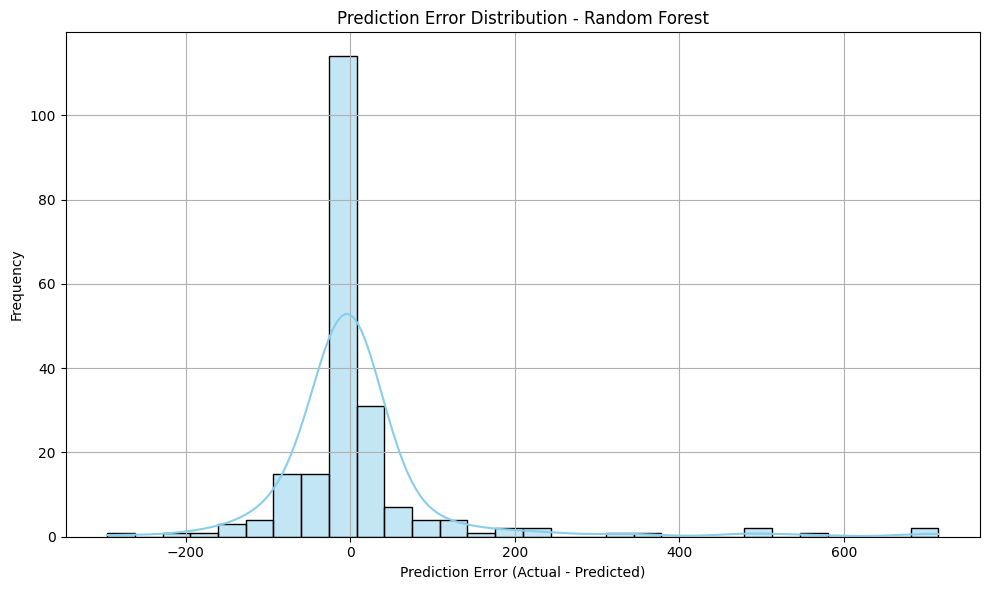

In [75]:
errors = y_test - predictions  # Use 'predictions' instead of undefined 'y_pred_rf'

plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30, color='skyblue')
plt.title("Prediction Error Distribution - Random Forest")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

From the first graph we can observe that most errors (Actual - Predicted) are near zero, indicating the model performs reasonably well in most cases.

There is a longer tail on the right suggests the model occasionally underestimates sales — it predicts less than the actual sales, which in other words is called **right skew**.
Of course there are some extreme errors (±200–600), meaning the model struggles with very high sales (likely outliers in the data).

From the table above and the frequency graph most predictions are close to the actual value.
But *outliers* or *irregular* spikes in sales are not captured well — which is typical for retail data where occasional promotions or stock clearances cause spikes.

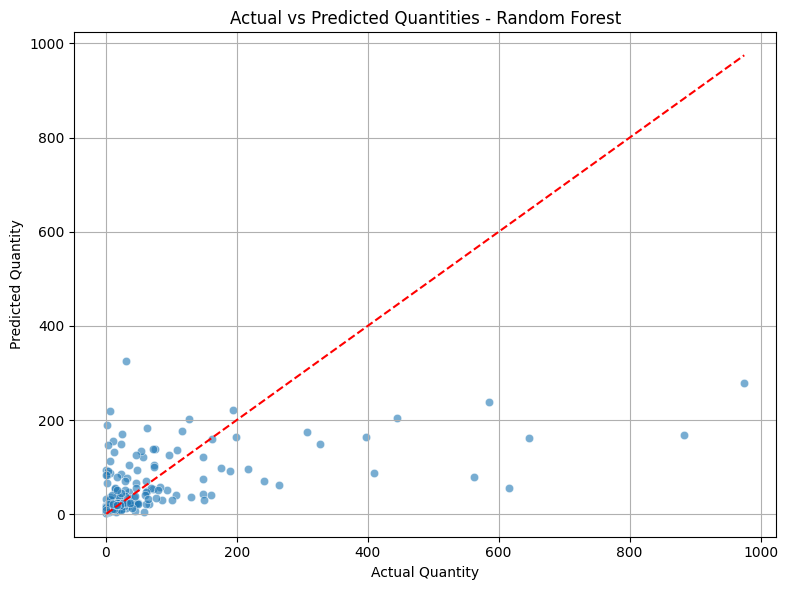

In [76]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Actual vs Predicted Quantities - Random Forest")
plt.xlabel("Actual Quantity")
plt.ylabel("Predicted Quantity")
plt.tight_layout()
plt.grid(True)
plt.show()

From the second graph we can see that most values are clustered below 200, indicating that most products usually sell in low quantities. Some predictions for high-quantity products (actual > 400) are consistently under the red ideal line, confirming underestimation. And finally in the lower ranges, predictions closely follow the ideal line, showing good accuracy there.

In other words the model works well for common sales levels (which is most of the data), but the generalization for rare high-sales cases is done poorly, which likely impacts overall R².

To sum up the **ML** Part of the notebook:
The Random Forest model is strong for baseline forecasting, especially for average product sales. However, unusual demand spikes or peak sales periods are under-modeled. This could be improved by:

- Including promotion or campaign flags

- Adding sales on SKUs

- Price range 

- Investigating each countries ideal product group

- Competitors

## ⚖️ Ethical Considerations in AI Forecasting

AI systems must support—not replace—human expertise. Forecasts are suggestions, not mandates.

To prevent misuse:
- All predictions include confidence levels.
- Managers can override any suggestion.
- Models are tested for fairness across regions and product types.

By embedding ethics in the pipeline, we avoid overreliance and protect against blind automation.

## 🌍 Broader Business and Societal Impact

A smarter inventory system reduces waste, improves efficiency, and ensures parents can always find safe, high-quality products when they need them. By avoiding overproduction and stockouts, this AI solution benefits both the company and society.

## 📌 Final Conclusion - Iteration 2

What went well:
1. Significant Feature Engineering Improvements
We introduced relevant features like `Lag_1/2/3`, `Rolling_Mean_3/6`, `Months_Since_Last_Sale`, `Is_November`, and `Current_Stock` which captured demand patterns more effectively. Additionally we added group-based features like `Group_Code_Encoded` and top-category indicators, helping contextualize products.

2. Model Comparison and Tuning
We successfully trained and compared multiple models: **LinearRegression**, **RandomForest**, **XGBoost**, **StackingRegressor**. Also when applying hyperparameter tuning, it boosted Random Forest R² from 0.27 to ~0.30, clearly improving predictive performance.

3. Model Evaluation 
We used residual distribution and scatter plots to deeply evaluate model behavior and uncover underprediction patterns.

4. Robust Data Pipeline & Cleaning
We cleaned the dataset with proper handling of discontinued SKUs, missing data, and feature consistency enabled stable model training.

Challenges & Limitations:
1. Difficulty Modeling High-Selling Outliers
Despite tuning, the models consistently underpredicted rare but high-quantity sales. These “spike” events skewed performance and increased RMSE.

2. XGBoost Underperformance
Initially underperformed with poor CV scores. Even after tuning, it lagged behind Random Forest, likely due to data size or skew.

3. Stacking Didn’t Help Much
Ensemble models like StackingRegressor with meta-learners (Linear, Ridge) didn’t outperform Random Forest — possibly due to overfitting or model similarity.

4. Lack of Seasonality & Promotion Features
The model lacks business context: *no promotion*, *holiday*, or *price discount* features, which may explain why it misses sudden demand surges.

Iteration 2 focused on building a solid predictive model using extensive feature engineering, model tuning, and evaluation. While the model isn’t perfect, it shows real potential to support business decisions around inventory and demand planning. With the addition of business-specific features like promotions or seasonality, its accuracy and value will significantly improve.

--------------------

# CONCLUSION

Over the course of all iterations, we progressively built a demand forecasting model tailored for KikkaBoo’s baby stroller sales. Starting with a simple baseline in Iteration 0, we incrementally added value by cleaning the data, engineering meaningful features, evaluating performance, and testing different algorithms.

Iteration 0 served as a basic starting point but quickly revealed structural issues — particularly the model treating each transaction as a separate observation, rather than recognizing aggregated sales behavior over time for each product. In Iteration 1, we corrected this by aggregating sales per SKU per month, aligning the data with the core idea of forecasting demand over time per product. This allowed us to treat each stroller's sales history as a time series. Iteration 2 focused on improving the dataset further, engineering time-aware features like lags, rolling means, and product lifecycle indicators. With this more refined foundation, we applied and tuned several models, ultimately finding that the Random Forest Regressor delivered the best results with an R² of 0.30.

While the model is not yet production-ready, it shows strong potential. With further integration of business-specific signals like promotions, competitor actions, holidays, and marketing campaigns, the predictive power could improve significantly. This project proves that even with limitations, data-driven forecasting can meaningfully support inventory planning and reduce the risk of stockouts or overstocking.

-------------------------------

## ⏏️ Interface

In [77]:
import gradio as gr
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error

# Model accuracy
r2 = r2_score(y_test, rf.predict(X_test))
mae = mean_absolute_error(y_test, rf.predict(X_test))

# Mapping for human-friendly product group labels
product_group_mapping = {
    'Adaptori za bebeshka kolichka': 0,
    'Aksesoari za kolichki': 1,
    'Bebeshki kolichki za bliznatsi': 2,
    'Bebeshki letni kolichki': 3,
    'Cybex': 4,
    'Kombinirani bebeshki kolichki 2 v 1': 5,
    'Kombinirani bebeshki kolichki 3 v 1': 6,
    'Obiknoveni bebeshki kolichki': 7
}

product_group_choices = list(product_group_mapping.keys())

# Prediction function
def predict_quantity_with_confidence(
    current_stock, lag_1, lag_2, lag_3, rolling_mean_3, rolling_mean_6,
    month_num, year, group_code_encoded, months_since_last_sale,
    product_group_label, is_november, is_new, is_discontinued,
    belongs_to_top_3, stockout_risk
):
    encoded_product_group = product_group_mapping[product_group_label]

    input_data = pd.DataFrame([{
        'Current_Stock': current_stock,
        'Lag_1': lag_1,
        'Lag_2': lag_2,
        'Lag_3': lag_3,
        'Rolling_Mean_3': rolling_mean_3,
        'Rolling_Mean_6': rolling_mean_6,
        'Month_Num': month_num,
        'Year': year,
        'Group_Code_Encoded': group_code_encoded,
        'Months_Since_Last_Sale': months_since_last_sale,
        'Product Group Label': encoded_product_group,
        'Is_November': int(is_november),
        'Is_New': int(is_new),
        'Is_Discontinued': int(is_discontinued),
        'Belongs_to_Top_3_Groups': int(belongs_to_top_3),
        'Stockout_Risk': int(stockout_risk)
    }])

    preds = [tree.predict(input_data)[0] for tree in rf.estimators_]
    prediction = np.mean(preds)
    std_dev = np.std(preds)

    return round(prediction, 2), round(std_dev, 2)

# Gradio interface
interface = gr.Interface(
    fn=predict_quantity_with_confidence,
    inputs=[
        gr.Number(label="Current Stock"),
        gr.Number(label="Sales Lag 1"),
        gr.Number(label="Sales Lag 2"),
        gr.Number(label="Sales Lag 3"),
        gr.Number(label="Rolling Mean 3"),
        gr.Number(label="Rolling Mean 6"),
        gr.Number(label="Month Number"),
        gr.Number(label="Year"),
        gr.Number(label="Group Code Encoded"),
        gr.Number(label="Months Since Last Sale"),
        gr.Dropdown(choices=product_group_choices, label="Product Group"),
        gr.Dropdown(choices=["0", "1"], label="Is November? (0 = No, 1 = Yes)", type="value"),
        gr.Dropdown(choices=["0", "1"], label="Is New Product?", type="value"),
        gr.Dropdown(choices=["0", "1"], label="Is Discontinued?", type="value"),
        gr.Dropdown(choices=["0", "1"], label="Belongs to Top 3 Group?", type="value"),
        gr.Dropdown(choices=["0", "1"], label="Stockout Risk?", type="value")
    ],
    outputs=[
        gr.Number(label="Predicted Quantity"),
        gr.Number(label="Model Uncertainty (±)")
    ],
    examples=[
        [
            150, 80, 60, 90, 76.7, 70.5, 5, 2025, 12, 1,
            'Bebeshki letni kolichki', '0', '0', '0', '1', '0'
        ]
    ],
    title="📦 KikkaBoo Demand Predictor",
    description=f"Enter product and seasonal data to predict demand quantity.\nModel Accuracy: R² = {r2:.2f}, MAE = {mae:.2f}.",
    allow_flagging="never"
)

interface.launch()


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gradio\interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\va

## 💡 Recommendations to client

As the developer, I recommend that this project should continue, but with all improvements mentioned in the conclusions.

The model shows promise and is directionally accurate.
With an R² score of 0.30, the model can already capture general sales trends and support high-level inventory planning, especially for average-demand products.

It should not yet be used for operational decision-making on its own.
Forecasting accuracy varies across products — particularly underperforming for outlier months or high-volume products. Decisions involving large orders or critical stock movements should still involve expert judgment.

Further improvements are strongly recommended:

- Integrate business context features: promotions, holidays, price changes, or bundle deals.

- Add real-time or external data sources (e.g., competitor activity, seasonality signals).

- Collaborate with sales and supply chain teams to validate predictions.

Consider phased implementation.
The model can be used in a "decision support" role, providing estimates alongside human forecasts to build trust and measure long-term effectiveness.

In conclusion, this model provides a strong foundation and is worth building upon. With additional data and business integration, it has the potential to evolve into a reliable tool for demand planning and stock optimization.

BONUS: If you are here it means the notebook caught your attention or you are somebody who is obligated to look through it whole.

Just saying that everything was justified thanks to the **semi-structured interview** we conducted with Kikka Group’s Business Director, asking open-ended and follow-up questions to deeply understand their challenges and domain-specific needs.
